# LoC batch thresholding notebook

This notebook loads a set of Z-tracks taken across an image volume from the lung-on-a-chip project and thresholds positive/negative expression of set markers based on a manual and unbiased assessment of the underlying images:

1. Load z-tracks, segmentation and images.
2. Initiate a Napari viewer with key bindings to annotate positive/negative expressing cells
3. Assess results
4. Quantify based on manually chosen thresholds

In [119]:
import btrack # import tracking software
import napari # image viewer
from skimage import io # image loader and viewer
import os # for filename manipulations
import glob # for more fn operations 
import pandas as pd # module for data org 
import matplotlib.pyplot as plt # module for plotting
import seaborn as sns # module for plotting
import numpy as np # for math operations
import re
from homuncu_loc import dataio
sns.set(font='Nimbus Sans', style = 'white') # my favourite formatting :)
sns.set_palette('PiYG') # my favourite colours :D 

## 1. Load images and labels

In [416]:
img_base_dir

In [460]:
search_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/' # search for image or input basename and dir 
image_base_name = '20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112.tif' 
img_base_dir = dataio.find_image_directory(search_dir, image_base_name) # img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
image_fn = os.path.join(img_base_dir, image_base_name)
image_id = dataio.ID_extractor(image_fn)
os.path.exists(image_fn)

True

In [400]:
#image = io.imread(image_fn) # load image

In [461]:
# base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses'
sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
sc_fns = glob.glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
print(sc_fns)

['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_z_tracks_masks.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5']


In [462]:
sc_fn =[fn for fn in sc_fns if fn.endswith('iat2.h5')][0]#sc_fns[-1] sc_fns[-1]#
# load labels (tracks and segmentation)
print(sc_fn)
if 'iat2' in sc_fn: 
    obj_type = 'obj_type_2'
elif '_z_tracks_masks' in sc_fn: 
    obj_type = 'obj_type_1'
with btrack.io.HDF5FileHandler(sc_fn, 
                                   'r', 
                                       obj_type=obj_type#'obj_type_1'#'obj_type_2'
                                   ) as reader:
        # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
        tracks = [t for t in reader.tracks if len(t) >= 3] #reader.tracks #
        # segmentation = reader.segmentation
# napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
# recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks)
output_dir = os.path.dirname(sc_fn)

[INFO][2023/11/01 10:55:59 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5...
[INFO][2023/11/01 10:55:59 am] Loading tracks/obj_type_2
[INFO][2023/11/01 10:55:59 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 10:55:59 am] Loading objects/obj_type_2 (27786, 5) (27786 filtered: None)


/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5


[INFO][2023/11/01 10:56:00 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5


# See if population can be thresholded based on sc max pix intensity distribution

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


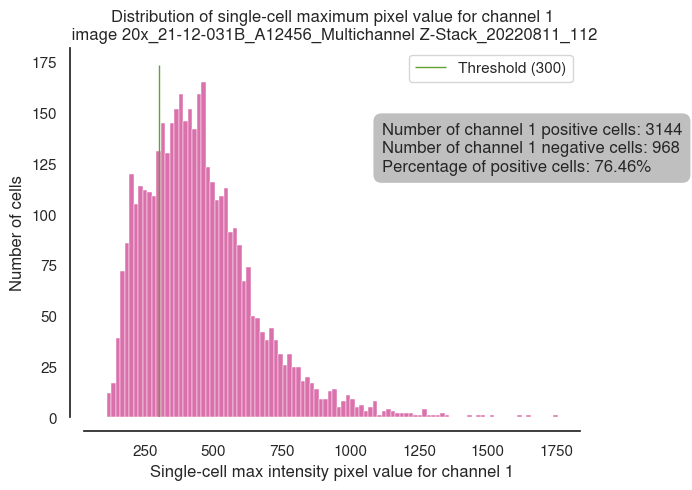

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


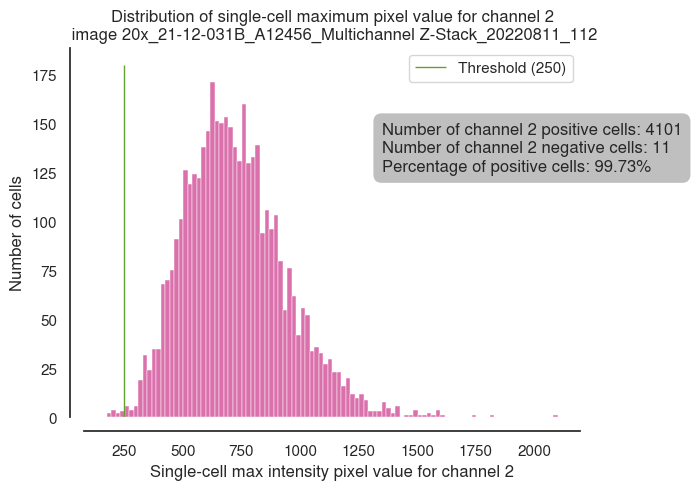

In [466]:
# for channel in [1,2]:# Example usage:
otsu = False
save = False #True
channel = 1
# intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
# intensities_array = np.array(intensities)
threshold = 300# int(calculate_otsu_threshold(intensities_array))
# Example usage:
plot_single_cell_intensities(tracks, channel, threshold, image_fn, save = save, otsu = otsu)

channel = 2
# intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
# intensities_array = np.array(intensities)
threshold = 250#int(calculate_otsu_threshold(intensities_array))
# Example usage:
plot_single_cell_intensities(tracks, channel, threshold, image_fn, 
                             # range = (0,5000),
                             save = save, otsu = otsu, 
                            remove_outliers=False) 

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


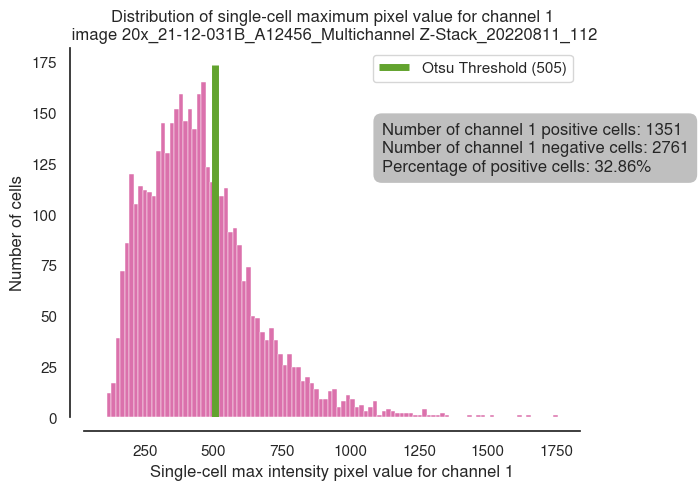

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


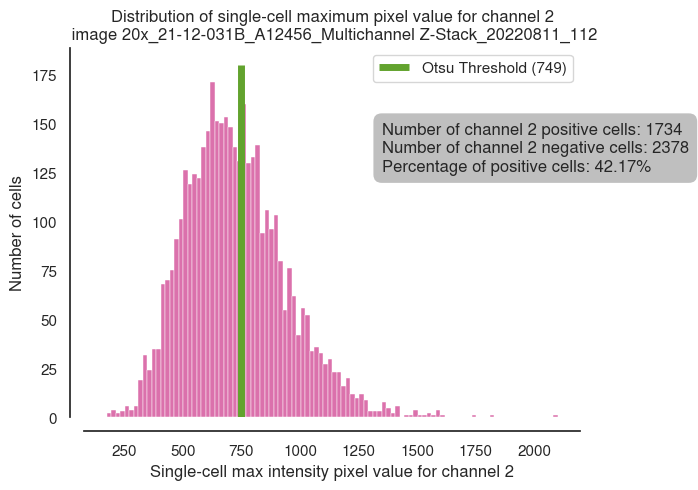

In [464]:
# for channel in [1,2]:# Example usage:
otsu = True
save = True#True
channel = 1
intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
intensities_array = np.array(intensities)
threshold = int(calculate_otsu_threshold(intensities_array))
# Example usage:
plot_single_cell_intensities(tracks, channel, threshold, image_fn, save = save, otsu = otsu)

channel = 2
intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
intensities_array = np.array(intensities)
threshold = int(calculate_otsu_threshold(intensities_array))
# Example usage:
plot_single_cell_intensities(tracks, channel, threshold, image_fn, 
                             # range = (0,5000),
                             save = save, otsu = otsu, 
                            remove_outliers=False)

In [308]:
print()

# Automated threshold?

In [66]:
global sc_base_dir

In [465]:
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_single_cell_intensities(tracks, channel, threshold, image_fn, range=False, save=False, otsu=False, remove_outliers=False):
    plt.clf()
    sc_intensities = [np.nanmax(t.properties['mean_intensity'][:, channel]) for t in tracks]

    if remove_outliers:
        Q1 = np.percentile(sc_intensities, 5)
        Q3 = np.percentile(sc_intensities, 95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        sc_intensities = [x for x in sc_intensities if lower_bound <= x <= upper_bound]
    
    if len(sc_intensities) == 0:
        print("No data points to plot after removing outliers.")
        return
    
    ax = sns.histplot(sc_intensities, bins=100)
    
    plt.vlines(x=threshold,
               ymax=ax.get_ylim()[-1],
               ymin=ax.get_ylim()[0],
               color=sns.color_palette('PiYG')[-1],
               linewidth=1)
    
    sns.despine(offset=10)
    plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
    plt.ylabel('Number of cells')
    
    n_positive = sum(i > threshold for i in sc_intensities)
    n_negative = len(sc_intensities) - n_positive
    percentage = (n_positive / len(sc_intensities)) * 100
    
    ax.text(0.6, 0.8, 
            f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
            transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

    image_name = os.path.basename(image_fn).replace('.tif', '')
    plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')

    if range:
        plt.xlim(range)
    
    if otsu:
        plt.legend([f'Otsu Threshold ({threshold})'], loc='upper right')
        if save:
            output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_otsu_threshold_quantification.png')
            plt.savefig(output_fn, bbox_inches='tight', dpi=314)
    else:
        plt.legend([f'Threshold ({threshold})'], loc='upper right')
        if save:
            output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_manual_graph_threshold_quantification.png')
            plt.savefig(output_fn, bbox_inches='tight', dpi=314)

    plt.show()


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


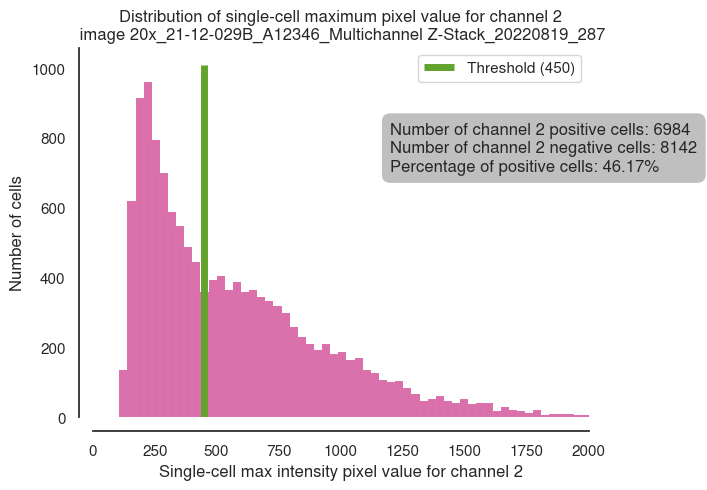

In [302]:
channel = 2
threshold = 450

sc_intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks]

ax = sns.histplot(sc_intensities, bins=2000)

plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],
           linewidth=5)

sns.despine(offset=10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')

n_positive = sum(i > threshold for i in sc_intensities)
n_negative = len(sc_intensities) - n_positive
percentage = (n_positive / len(sc_intensities)) * 100

ax.text(0.6, 0.8, 
        f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif', '')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')

# if range:
#     plt.xlim(range)
plt.xlim(0,2000)
otsu = False
if otsu:
    plt.legend([f'Otsu Threshold ({threshold})'], loc='upper right')
    if save:
        output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_otsu_threshold_quantification.png')
        plt.savefig(output_fn, bbox_inches='tight', dpi=314)
else:
    plt.legend([f'Threshold ({threshold})'], loc='upper right')
    if save:
        output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_manual_graph_threshold_quantification.png')
        plt.savefig(output_fn, bbox_inches='tight', dpi=314)

plt.show()

# Previous threshold

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of single-cell maximum pixel value for channel 1\n image 20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442')

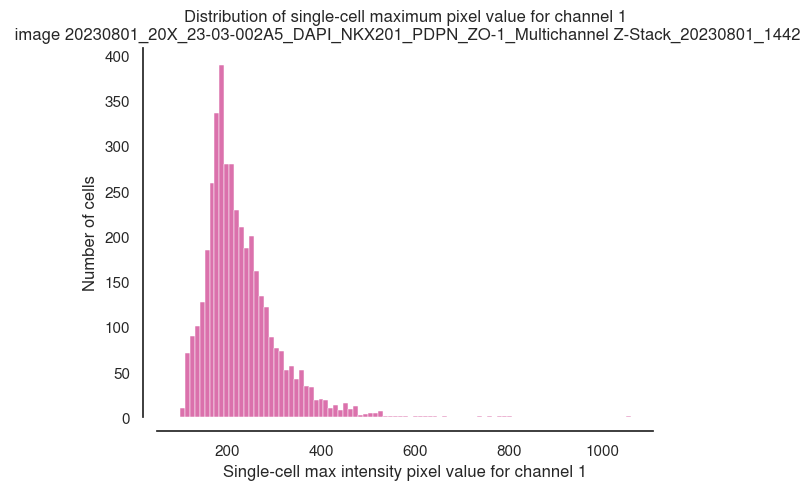

In [35]:
channel = 1
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
ax = sns.histplot(sc_intensities)
# plt.vlines(x=threshold,
#            ymax=ax.get_ylim()[-1],
#            ymin=ax.get_ylim()[0],
#            color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
#            linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
# plt.legend([f'Threshold ({threshold})'], loc='lower right')
# ax.text(0.4, 0.95, 
#         f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
#         transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif','')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')
# output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold_quantification.png')
# plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of single-cell maximum pixel value for channel 2\n image 20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442')

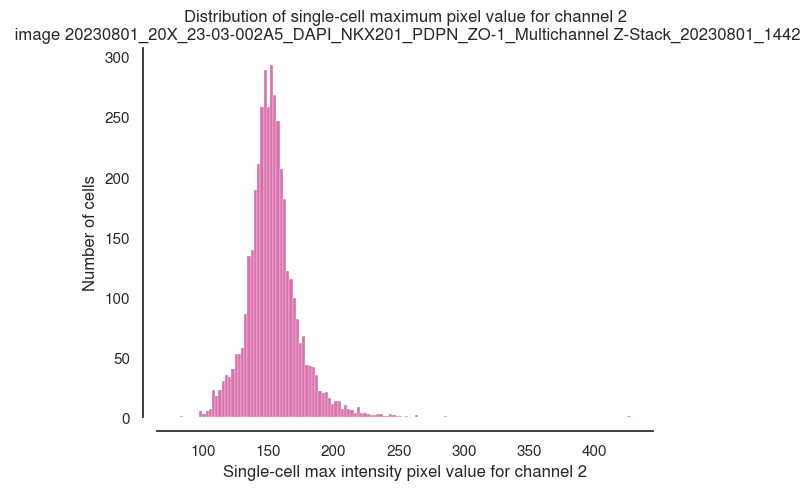

In [36]:
channel = 2
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
ax = sns.histplot(sc_intensities)
# plt.vlines(x=threshold,
#            ymax=ax.get_ylim()[-1],
#            ymin=ax.get_ylim()[0],
#            color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
#            linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
# plt.legend([f'Threshold ({threshold})'], loc='lower right')
# ax.text(0.4, 0.95, 
#         f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
#         transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif','')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')
# output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold_quantification.png')
# plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


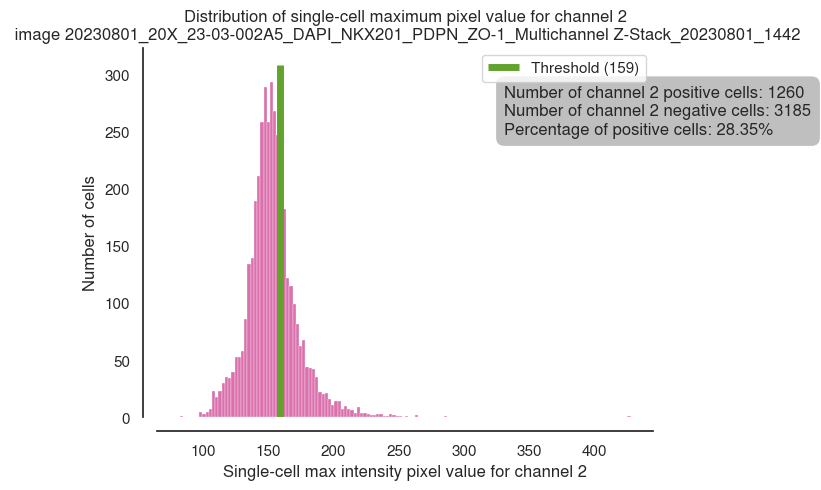

In [48]:
# Example usage:
intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
intensities_array = np.array(intensities)
threshold = int(calculate_otsu_threshold(intensities_array))
# Example usage:
plot_single_cell_intensities(tracks, channel, threshold, image_fn)

In [148]:
v = napari.Viewer(title = image_id)
# v.add_image(image, channel_axis = -1)
v.add_tracks(napari_tracks)
v.add_labels(recolored_segmentation)

<Labels layer 'recolored_segmentation' at 0x7fb46b12e5b0>

# Iterate over all files and show distribution

In [476]:
def find_filename(filenames, primary_criteria, secondary_criteria):
    primary_matches = [fn for fn in filenames if primary_criteria in fn]
    if primary_matches:
        return primary_matches[0]
    secondary_matches = [fn for fn in filenames if secondary_criteria in fn]
    if secondary_matches:
        return secondary_matches[0]
    return None
from tqdm.auto import tqdm

In [473]:
fns = """20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112
20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113
20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114
20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121
20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122
20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123
20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194
20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195
20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245
20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246
20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284
20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286
20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287
20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434
20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435
20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436
20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438
20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439
20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440
20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441
20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442
20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443
20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444
20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445
20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446
20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447
20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448
20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449
20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450
20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451
20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452"""
fns = fns.splitlines()

  0%|          | 0/36 [00:00<?, ?it/s]

[INFO][2023/11/01 11:06:08 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5...
[INFO][2023/11/01 11:06:08 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:06:08 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:06:08 am] Loading objects/obj_type_2 (27786, 5) (27786 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_z_tracks_masks.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5']


[INFO][2023/11/01 11:06:08 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


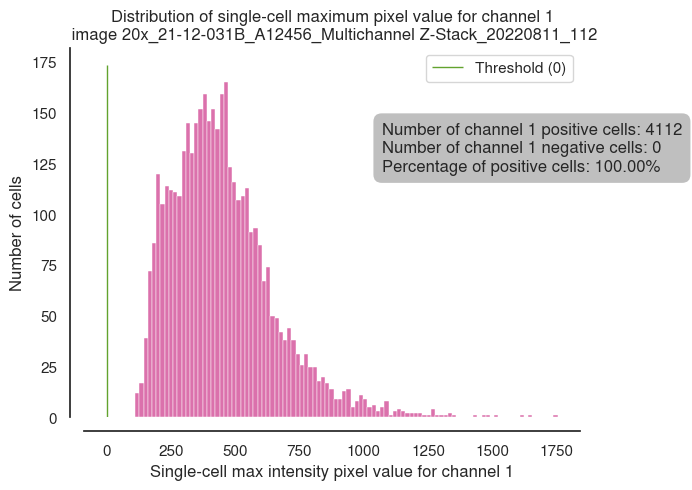

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


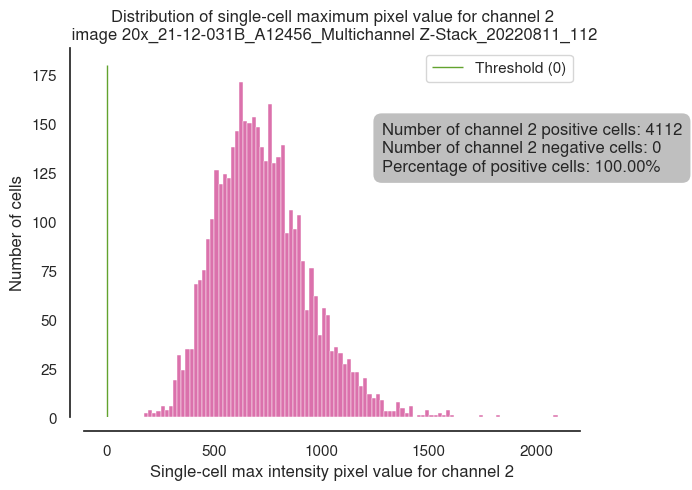

[INFO][2023/11/01 11:06:21 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5...
[INFO][2023/11/01 11:06:21 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:06:21 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5']


[INFO][2023/11/01 11:06:22 am] Loading objects/obj_type_1 (44449, 5) (44449 filtered: None)
[INFO][2023/11/01 11:06:23 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


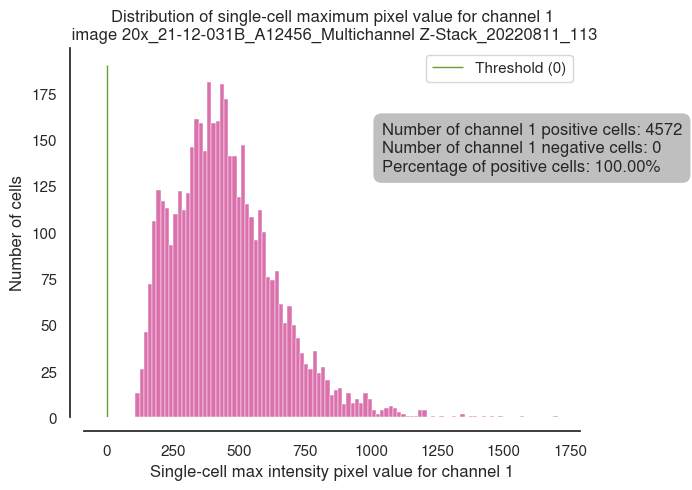

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


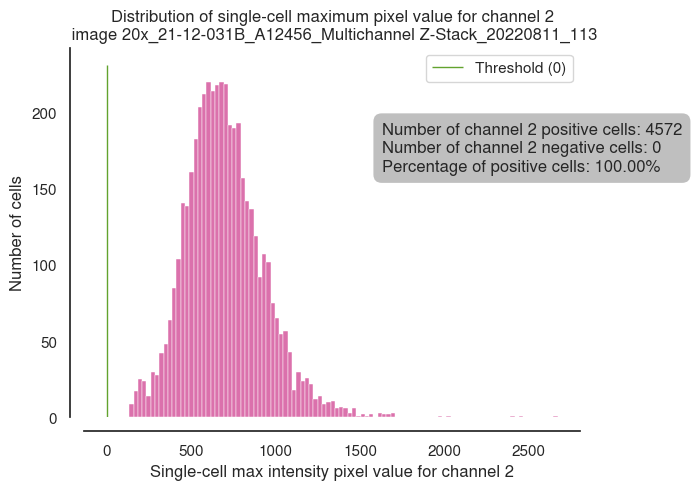

[INFO][2023/11/01 11:06:36 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5...
[INFO][2023/11/01 11:06:36 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:06:36 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:06:36 am] Loading objects/obj_type_2 (23232, 5) (23232 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5']


[INFO][2023/11/01 11:06:37 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


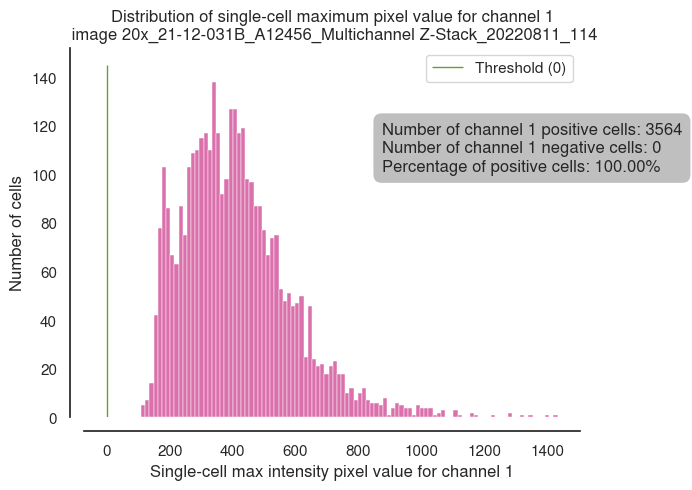

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


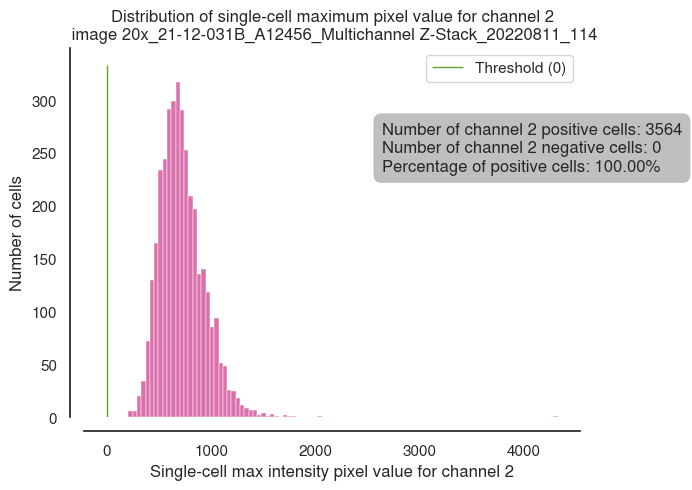

[INFO][2023/11/01 11:06:48 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5...
[INFO][2023/11/01 11:06:48 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:06:48 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5']


[INFO][2023/11/01 11:06:48 am] Loading objects/obj_type_1 (53982, 5) (53982 filtered: None)
[INFO][2023/11/01 11:06:50 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


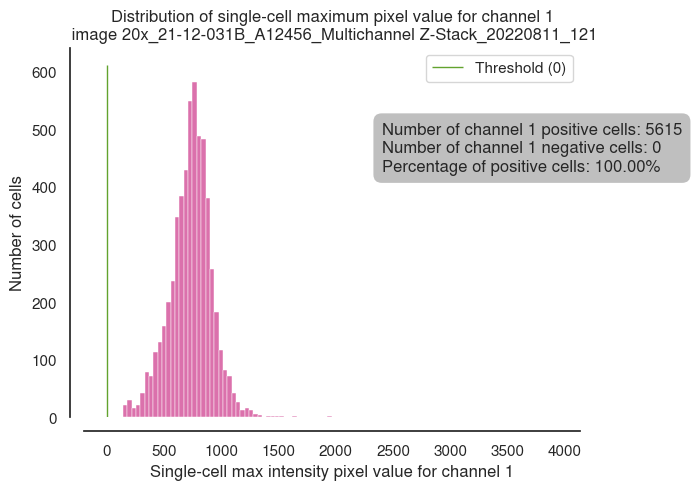

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


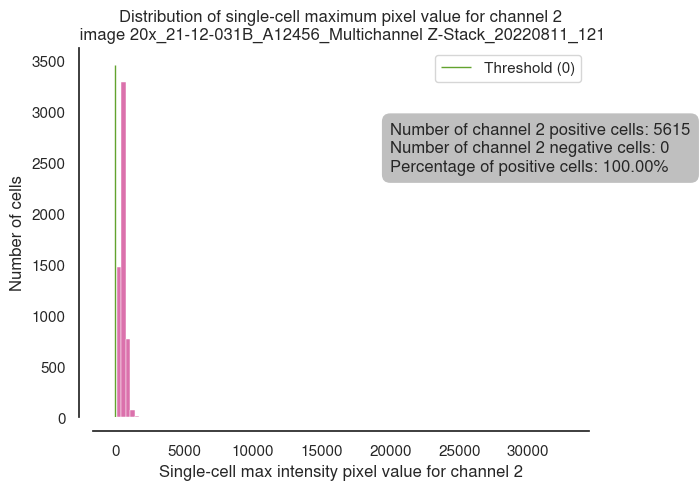

[INFO][2023/11/01 11:07:01 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5...
[INFO][2023/11/01 11:07:01 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:07:01 am] Loading LBEP/obj_type_1
[INFO][2023/11/01 11:07:01 am] Loading objects/obj_type_1 (57959, 5) (57959 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5']


[INFO][2023/11/01 11:07:02 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


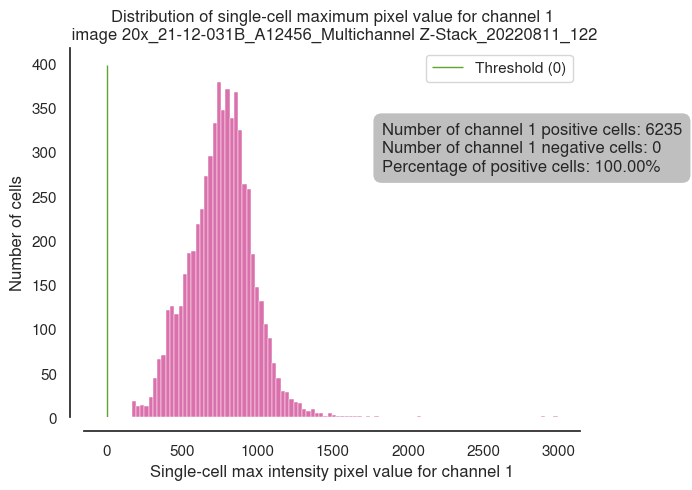

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


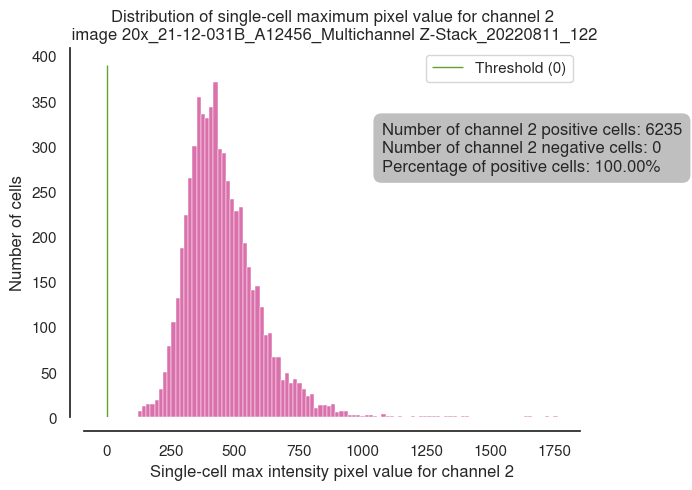

[INFO][2023/11/01 11:07:11 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5...
[INFO][2023/11/01 11:07:11 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:07:11 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5']


[INFO][2023/11/01 11:07:11 am] Loading objects/obj_type_1 (54676, 5) (54676 filtered: None)
[INFO][2023/11/01 11:07:13 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


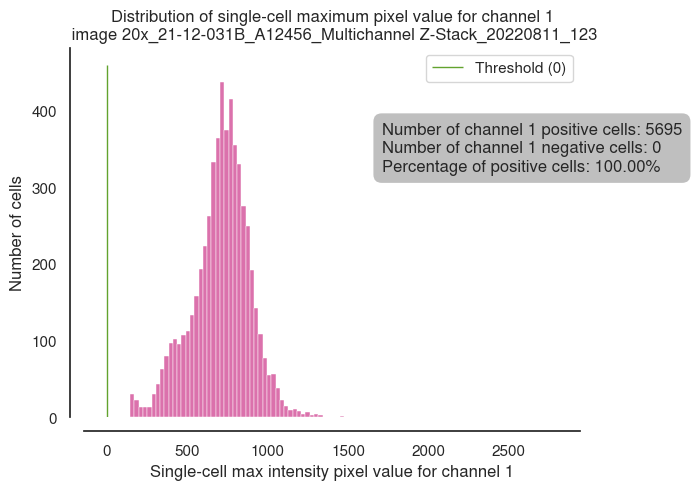

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


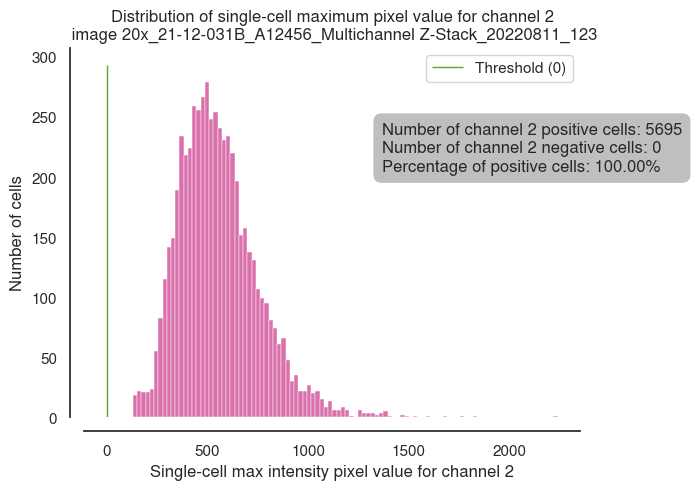

[INFO][2023/11/01 11:07:22 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5...
[INFO][2023/11/01 11:07:22 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:07:22 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5']


[INFO][2023/11/01 11:07:22 am] Loading objects/obj_type_1 (75007, 5) (75007 filtered: None)
[INFO][2023/11/01 11:07:23 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


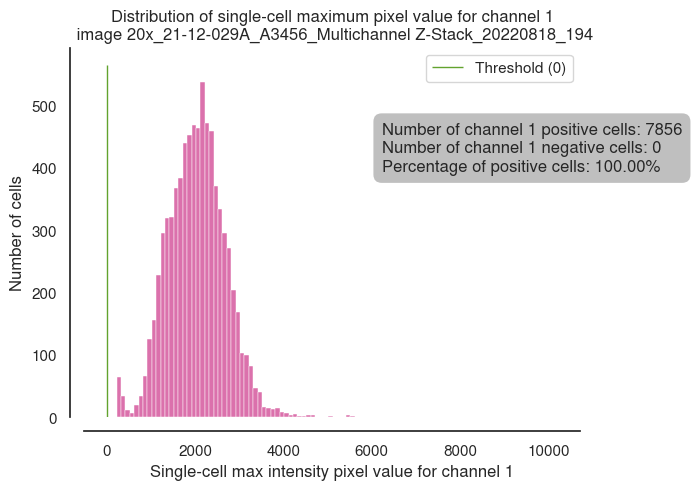

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


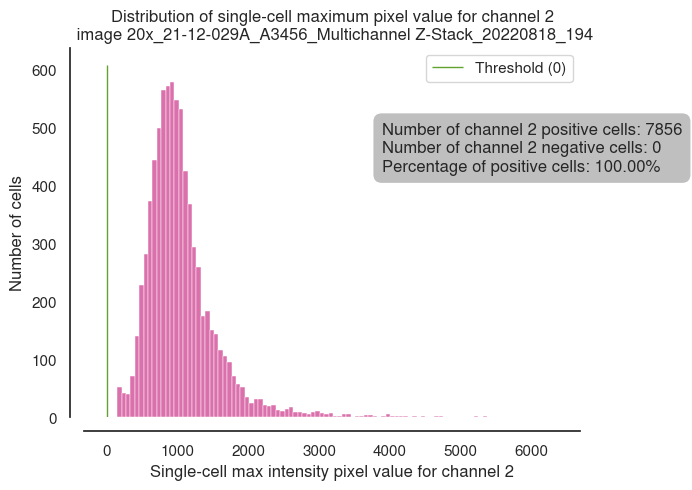

[INFO][2023/11/01 11:07:34 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5...
[INFO][2023/11/01 11:07:34 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:07:34 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5']


[INFO][2023/11/01 11:07:34 am] Loading objects/obj_type_1 (71466, 5) (71466 filtered: None)
[INFO][2023/11/01 11:07:36 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


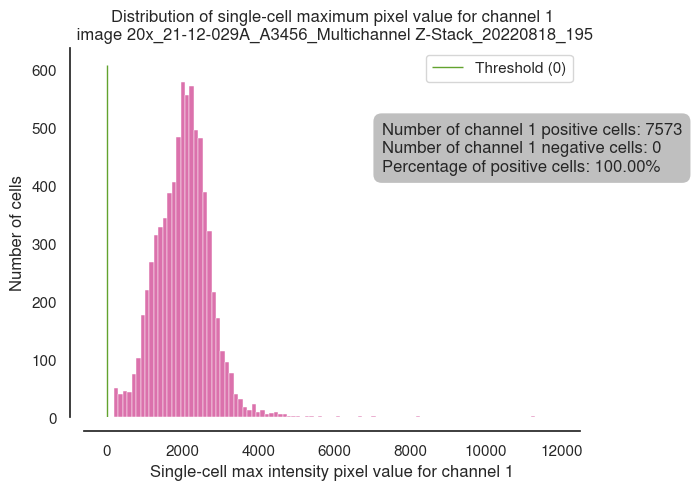

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


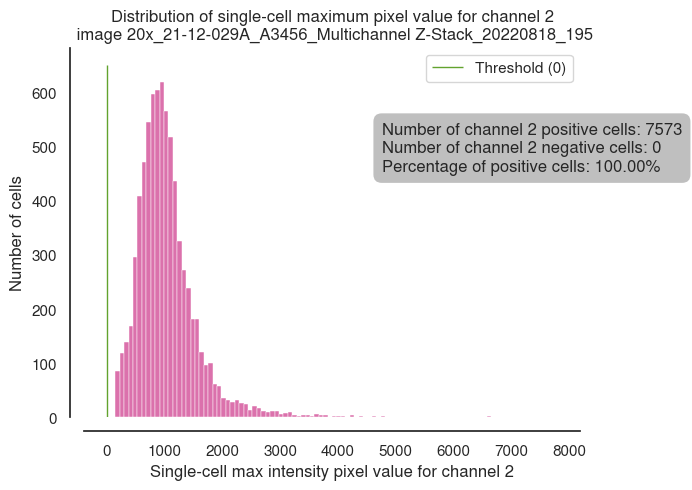

[INFO][2023/11/01 11:07:47 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5...


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5']


[INFO][2023/11/01 11:07:48 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:07:48 am] Loading LBEP/obj_type_1
[INFO][2023/11/01 11:07:48 am] Loading objects/obj_type_1 (68006, 5) (68006 filtered: None)
[INFO][2023/11/01 11:07:49 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befor

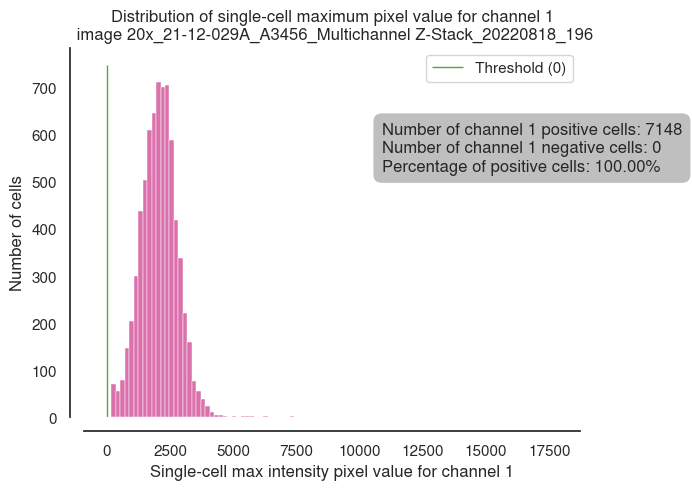

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


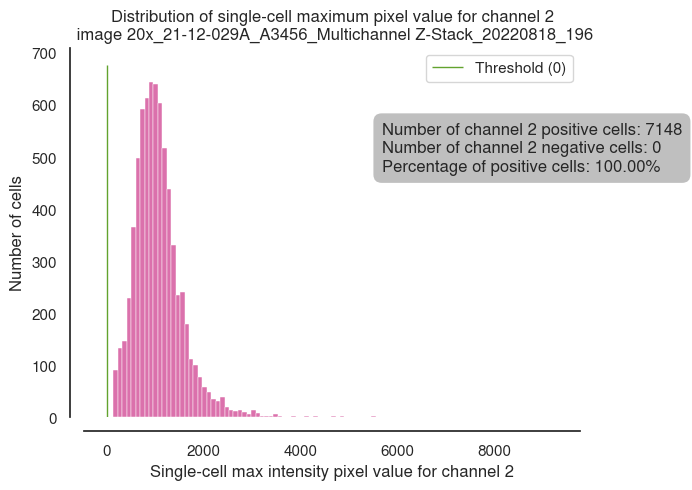

[INFO][2023/11/01 11:08:16 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5...


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5']


[INFO][2023/11/01 11:08:16 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:08:16 am] Loading LBEP/obj_type_1
[INFO][2023/11/01 11:08:16 am] Loading objects/obj_type_1 (41128, 5) (41128 filtered: None)
[INFO][2023/11/01 11:08:17 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN be

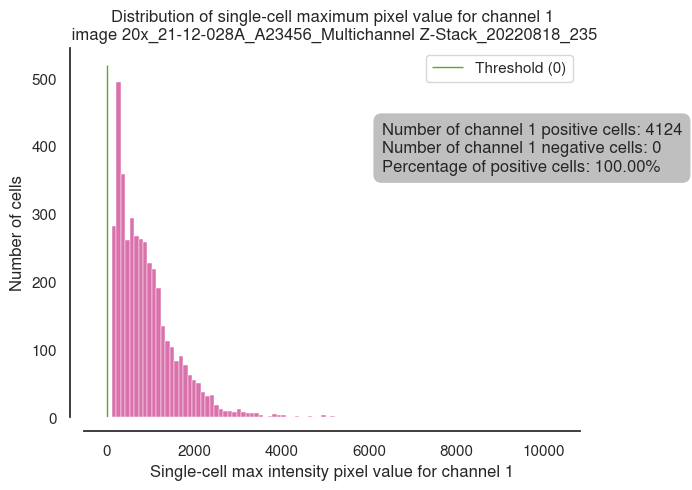

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


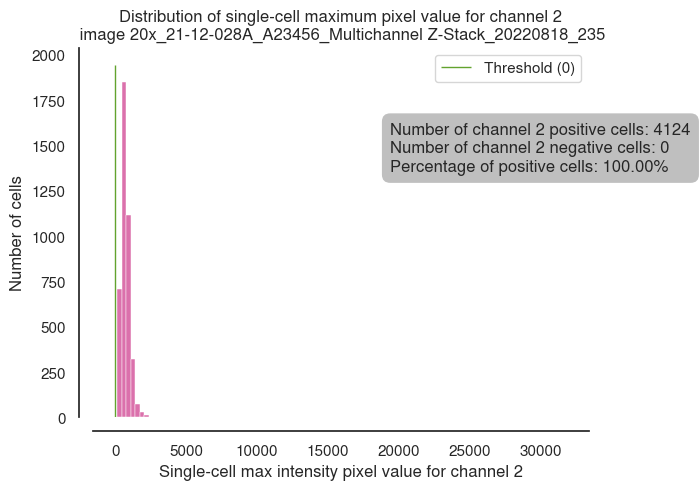

[INFO][2023/11/01 11:08:46 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5...
[INFO][2023/11/01 11:08:46 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:08:46 am] Loading LBEP/obj_type_1
[INFO][2023/11/01 11:08:46 am] Loading objects/obj_type_1 (44416, 5) (44416 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5']


[INFO][2023/11/01 11:08:47 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


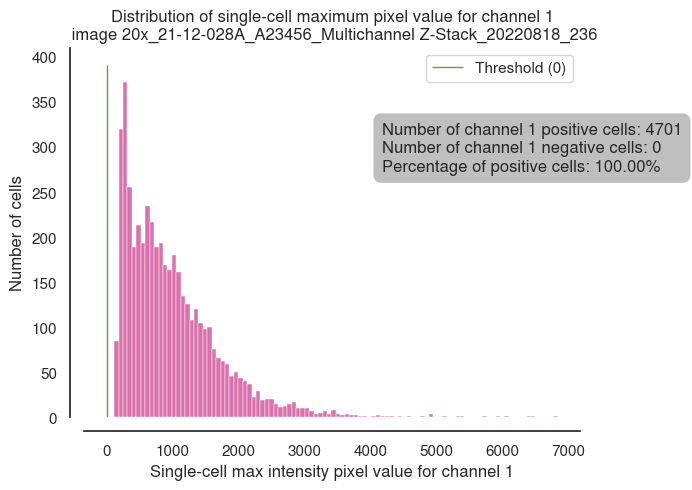

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


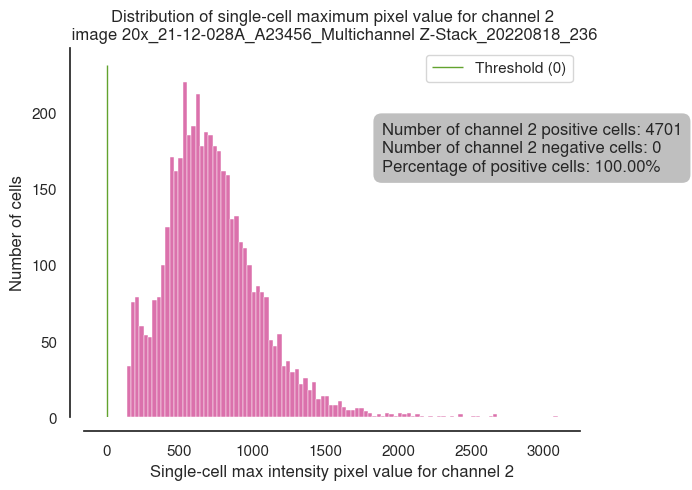

[INFO][2023/11/01 11:09:06 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5...
[INFO][2023/11/01 11:09:06 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:09:06 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:09:06 am] Loading objects/obj_type_2 (28241, 5) (28241 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5']


[INFO][2023/11/01 11:09:07 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


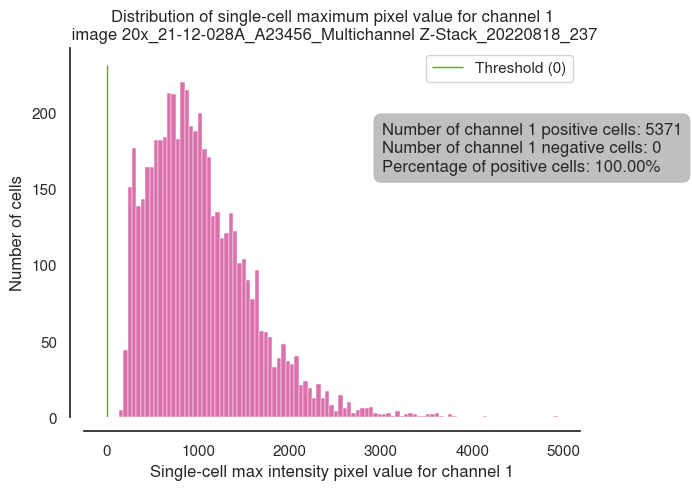

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


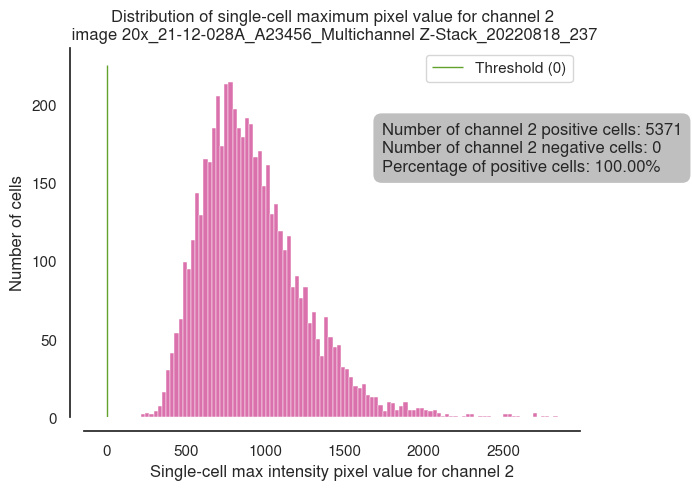

[INFO][2023/11/01 11:09:22 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5...
[INFO][2023/11/01 11:09:22 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:09:22 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5']


[INFO][2023/11/01 11:09:22 am] Loading objects/obj_type_1 (54625, 5) (54625 filtered: None)
[INFO][2023/11/01 11:09:23 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


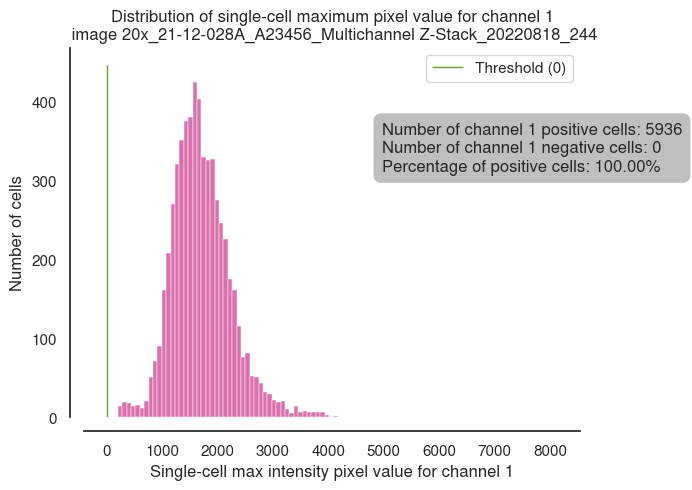

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


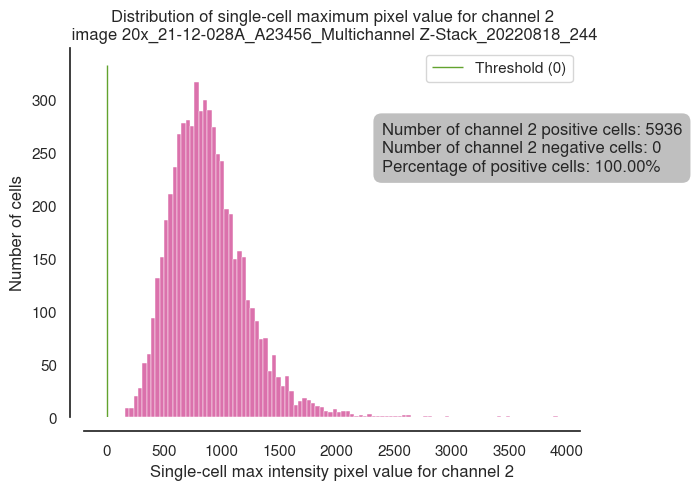

[INFO][2023/11/01 11:09:38 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5...
[INFO][2023/11/01 11:09:38 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:09:38 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5']


[INFO][2023/11/01 11:09:38 am] Loading objects/obj_type_1 (53979, 5) (53979 filtered: None)
[INFO][2023/11/01 11:09:40 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


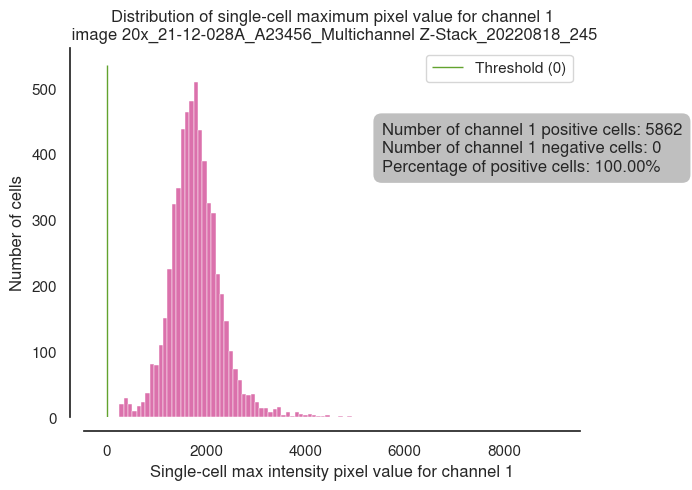

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


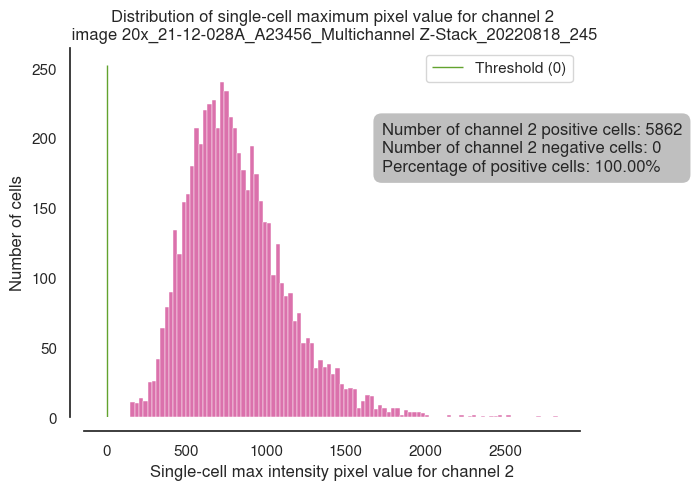

[INFO][2023/11/01 11:09:57 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5...
[INFO][2023/11/01 11:09:57 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:09:57 am] Loading LBEP/obj_type_1
[INFO][2023/11/01 11:09:57 am] Loading objects/obj_type_1 (52314, 5) (52314 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5']


[INFO][2023/11/01 11:09:58 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


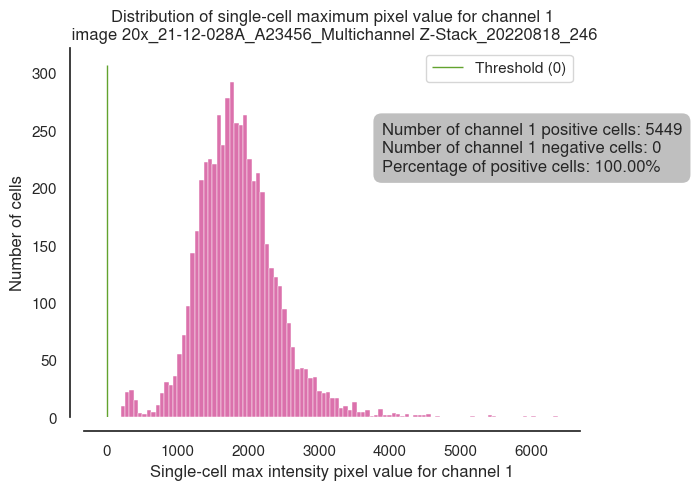

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


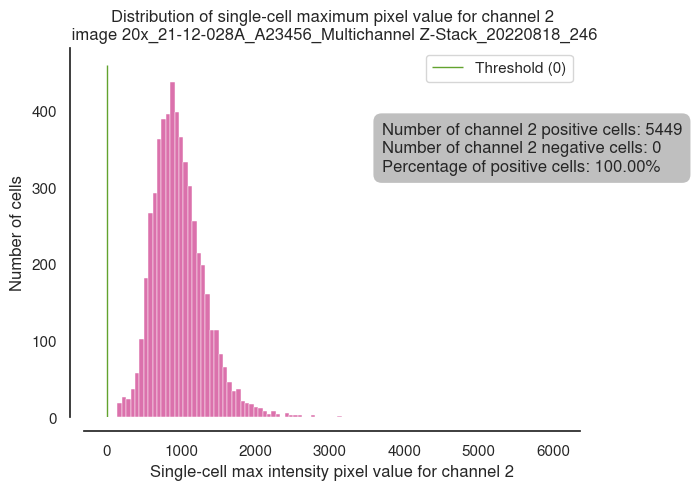

[INFO][2023/11/01 11:10:17 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5...
[INFO][2023/11/01 11:10:17 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:10:17 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5']


[INFO][2023/11/01 11:10:17 am] Loading objects/obj_type_1 (11889, 5) (11889 filtered: None)
[INFO][2023/11/01 11:10:18 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


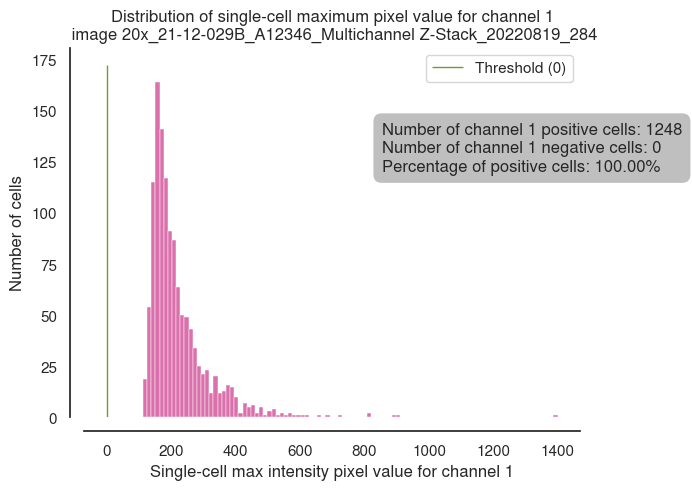

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


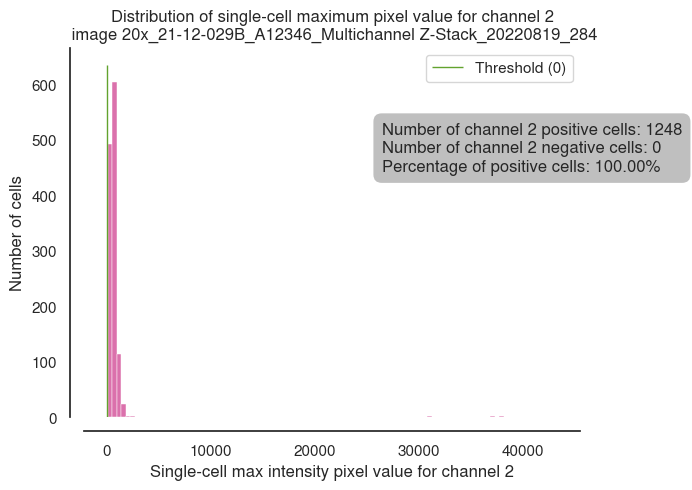

[INFO][2023/11/01 11:10:38 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5...
[INFO][2023/11/01 11:10:38 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:10:38 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5']


[INFO][2023/11/01 11:10:38 am] Loading objects/obj_type_1 (38518, 5) (38518 filtered: None)
[INFO][2023/11/01 11:10:39 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


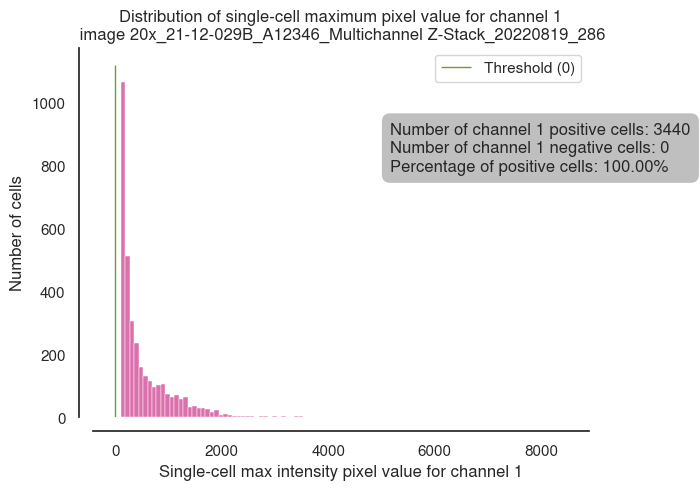

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


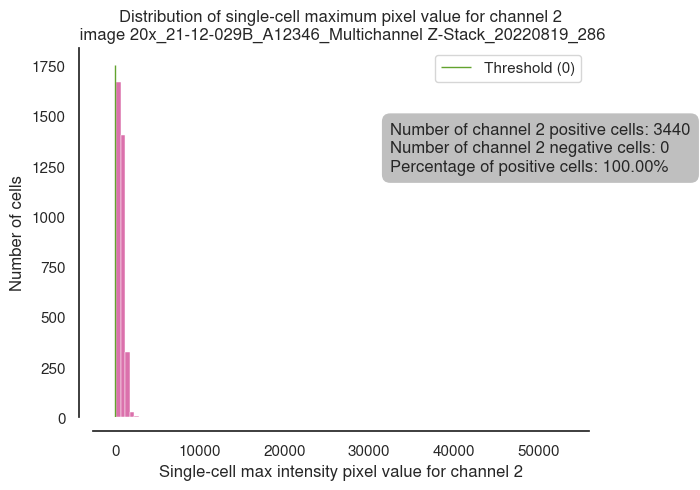

[INFO][2023/11/01 11:10:56 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5...
[INFO][2023/11/01 11:10:56 am] Loading tracks/obj_type_1
[INFO][2023/11/01 11:10:56 am] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5']


[INFO][2023/11/01 11:10:56 am] Loading objects/obj_type_1 (50455, 5) (50455 filtered: None)
[INFO][2023/11/01 11:10:58 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


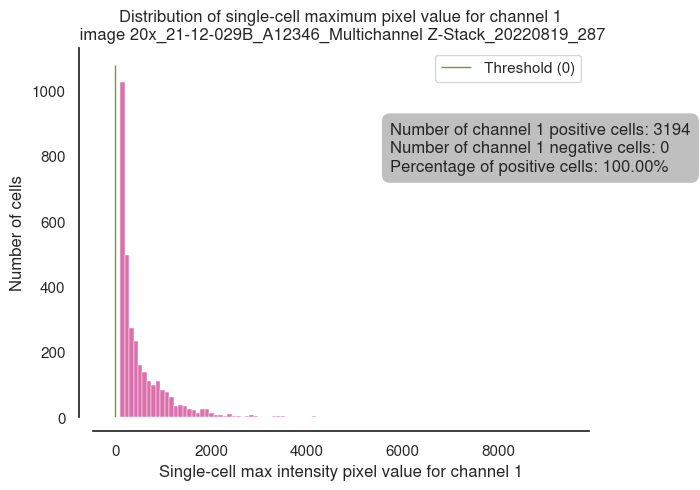

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


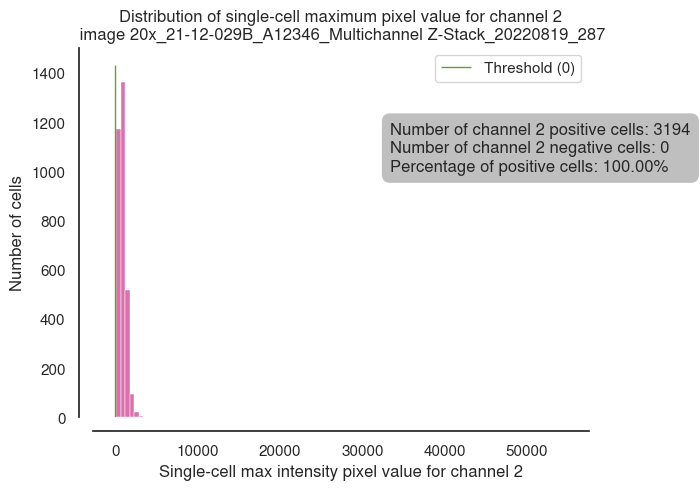

[INFO][2023/11/01 11:11:20 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5...
[INFO][2023/11/01 11:11:20 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:11:20 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_z_tracks_masks.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5']


[INFO][2023/11/01 11:11:21 am] Loading objects/obj_type_2 (52662, 5) (52662 filtered: None)
[INFO][2023/11/01 11:11:21 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


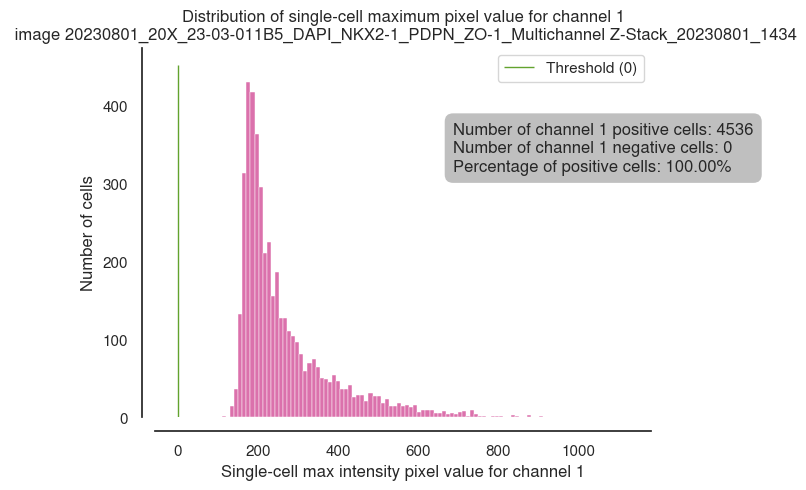

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


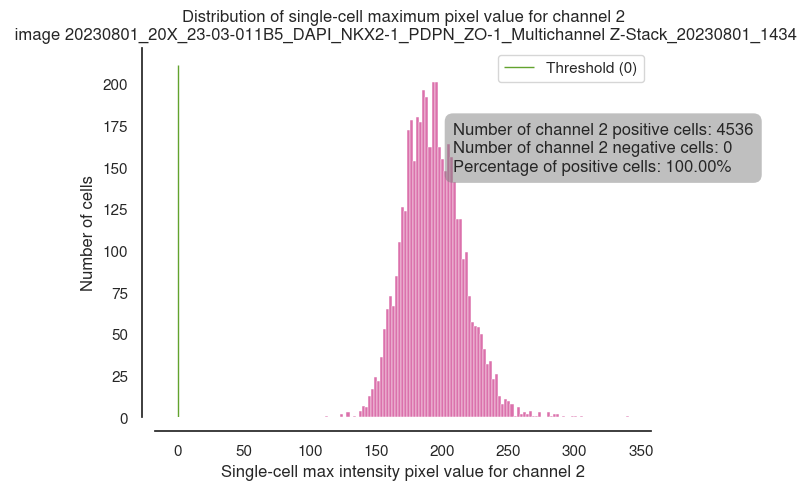

[INFO][2023/11/01 11:11:38 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5...
[INFO][2023/11/01 11:11:38 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:11:38 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:11:38 am] Loading objects/obj_type_2 (50760, 5) (50760 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5']


[INFO][2023/11/01 11:11:39 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


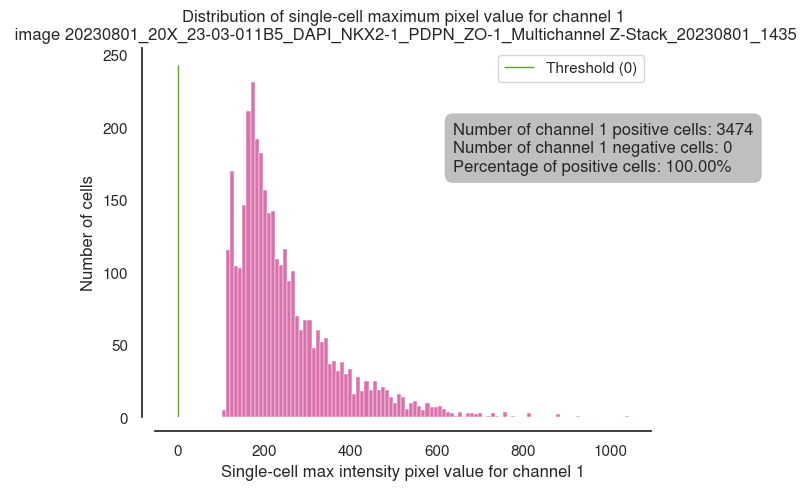

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


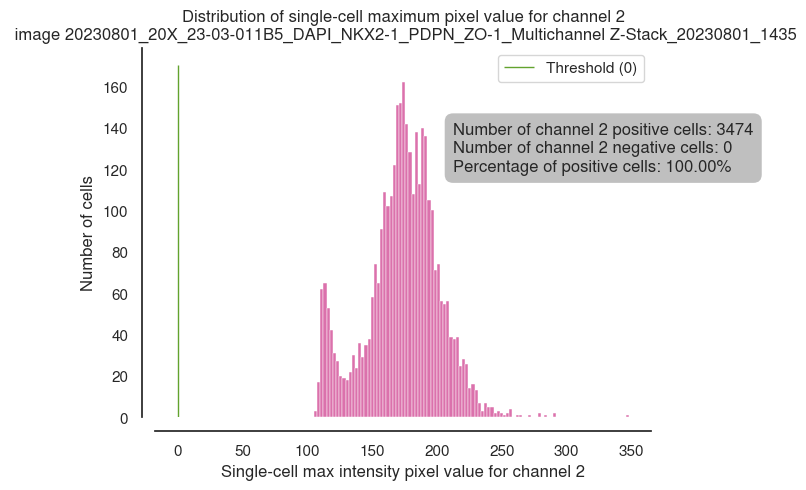

[INFO][2023/11/01 11:12:02 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5...
[INFO][2023/11/01 11:12:02 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:12:02 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5']


[INFO][2023/11/01 11:12:02 am] Loading objects/obj_type_2 (55607, 5) (55607 filtered: None)
[INFO][2023/11/01 11:12:04 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


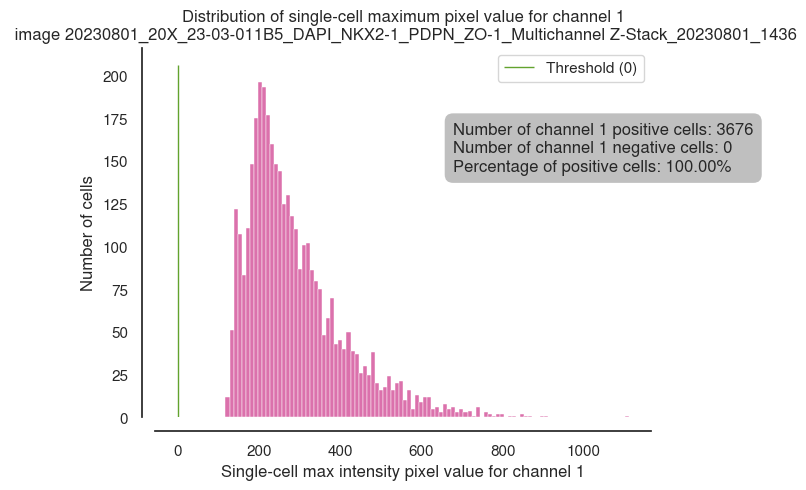

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


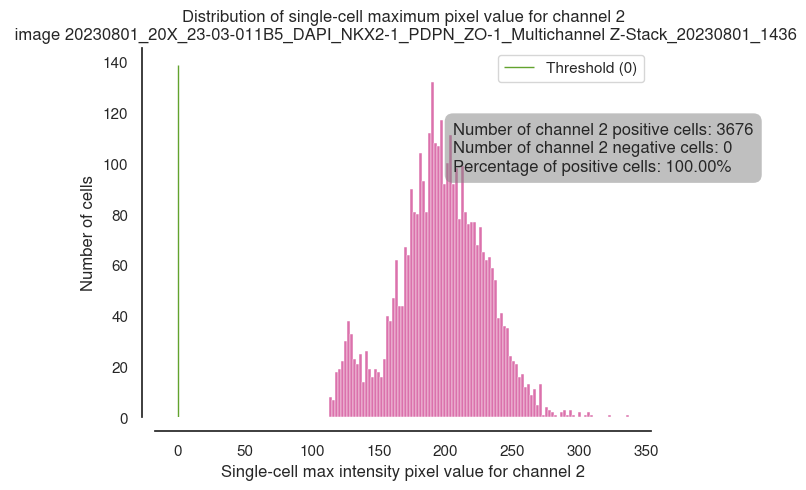

[INFO][2023/11/01 11:12:24 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5...


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat1.h5']


[INFO][2023/11/01 11:12:25 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:12:25 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:12:25 am] Loading objects/obj_type_2 (51277, 5) (51277 filtered: None)
[INFO][2023/11/01 11:12:26 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu

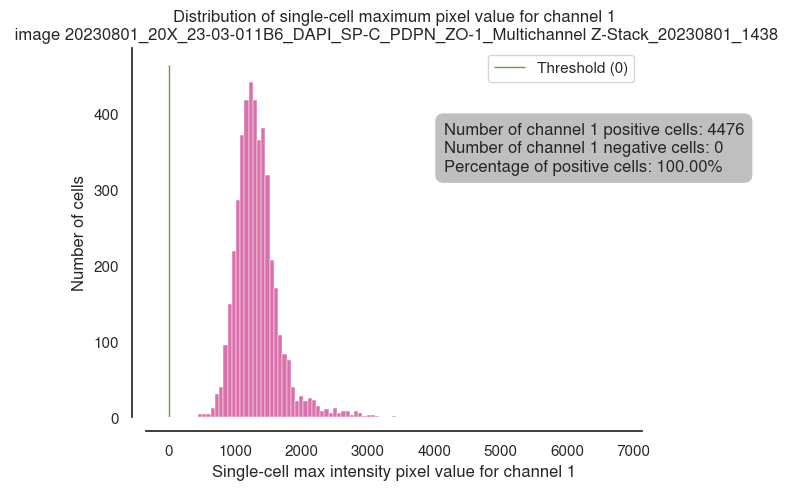

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


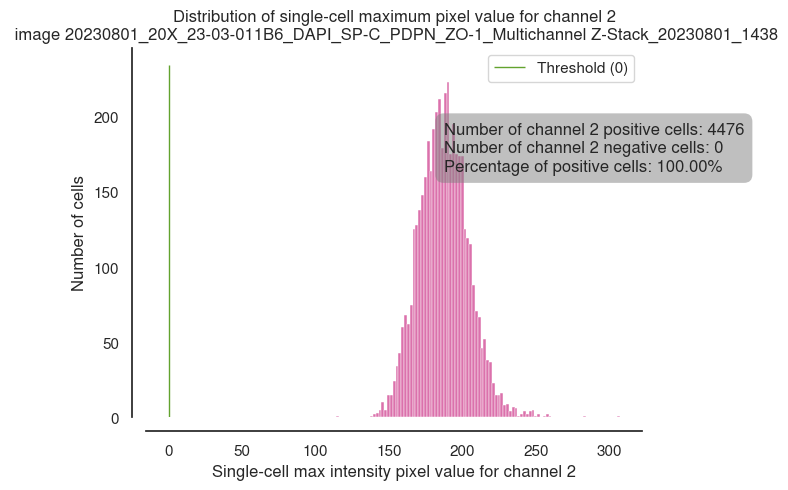

[INFO][2023/11/01 11:12:43 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5...
[INFO][2023/11/01 11:12:44 am] Loading tracks/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5']


[INFO][2023/11/01 11:12:44 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:12:44 am] Loading objects/obj_type_2 (45921, 5) (45921 filtered: None)
[INFO][2023/11/01 11:12:45 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_cont

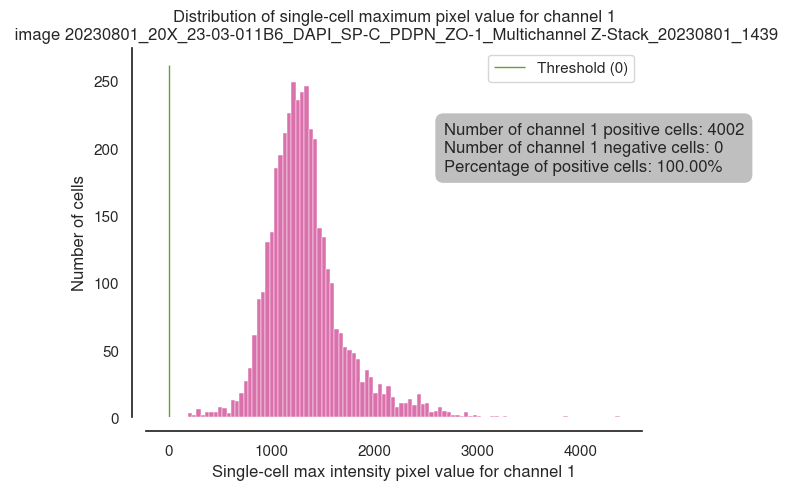

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


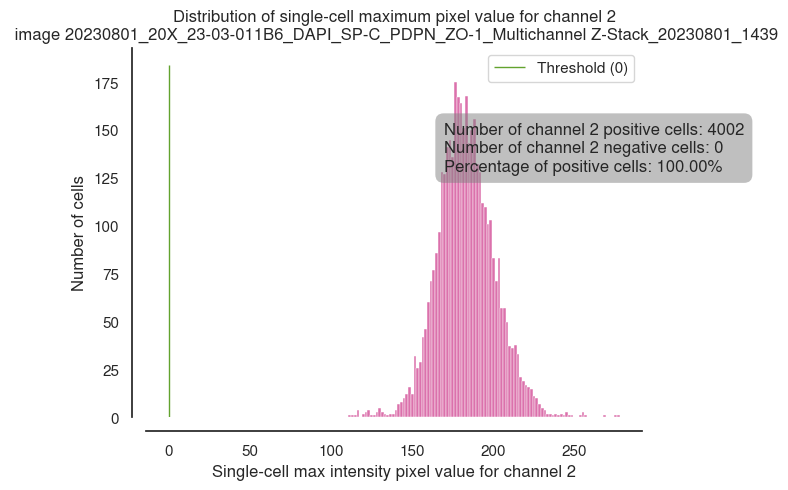

[INFO][2023/11/01 11:13:06 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5...
[INFO][2023/11/01 11:13:06 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:13:06 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:13:07 am] Loading objects/obj_type_2 (37477, 5) (37477 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat1.h5']


[INFO][2023/11/01 11:13:07 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


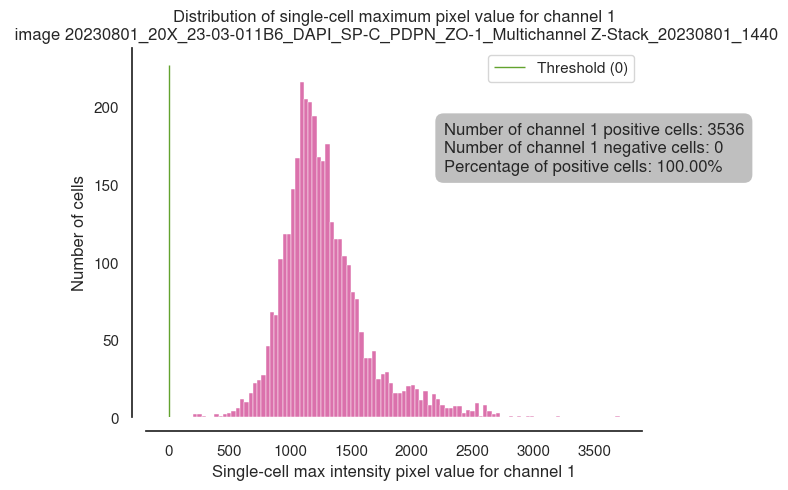

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


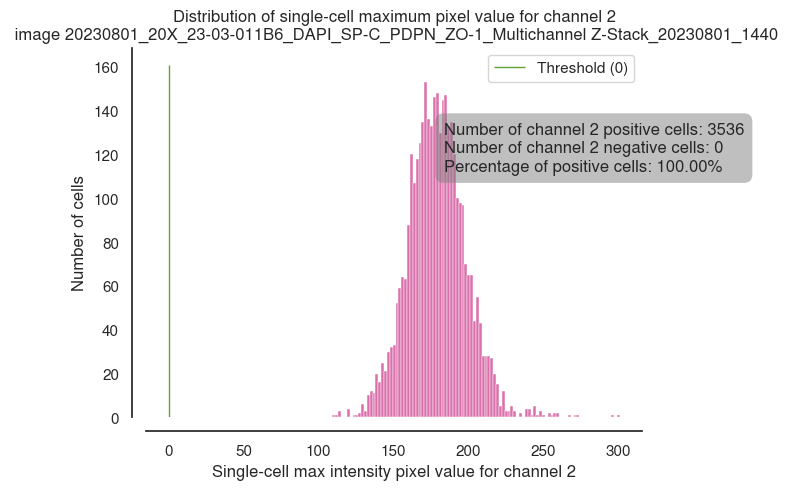

[INFO][2023/11/01 11:13:28 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5...
[INFO][2023/11/01 11:13:28 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:13:28 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:13:28 am] Loading objects/obj_type_2 (49364, 5) (49364 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_z_tracks_masks.h5']


[INFO][2023/11/01 11:13:28 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


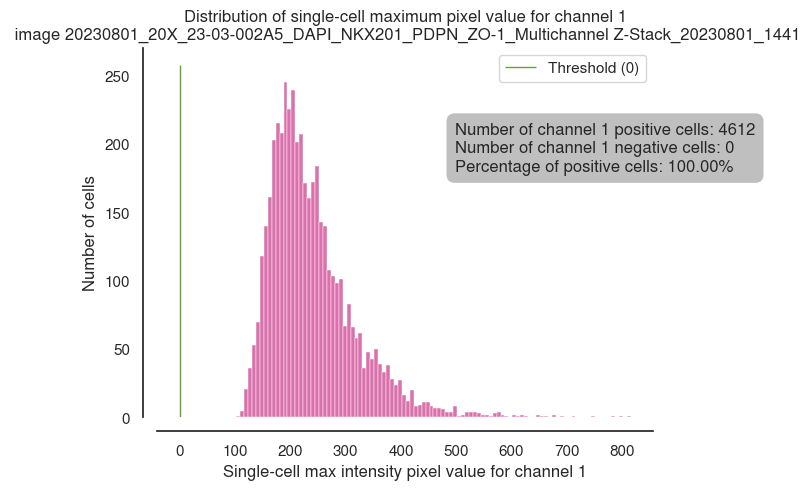

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


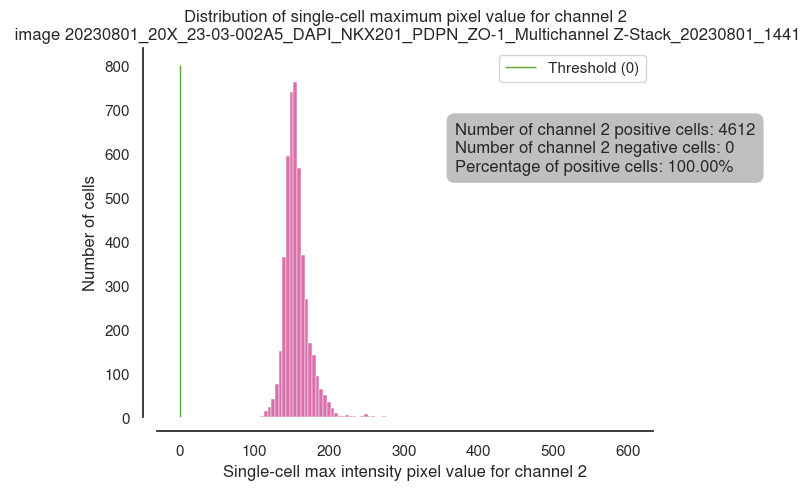

[INFO][2023/11/01 11:13:40 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5...
[INFO][2023/11/01 11:13:40 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:13:40 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5']


[INFO][2023/11/01 11:13:40 am] Loading objects/obj_type_2 (30775, 5) (30775 filtered: None)
[INFO][2023/11/01 11:13:41 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


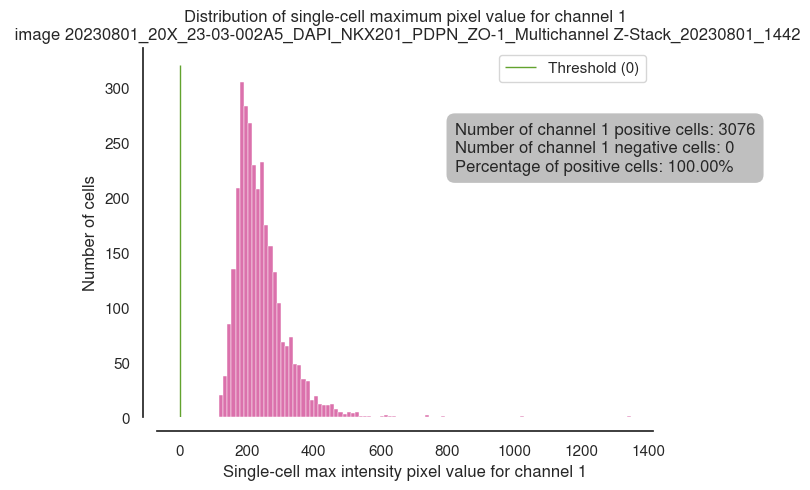

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


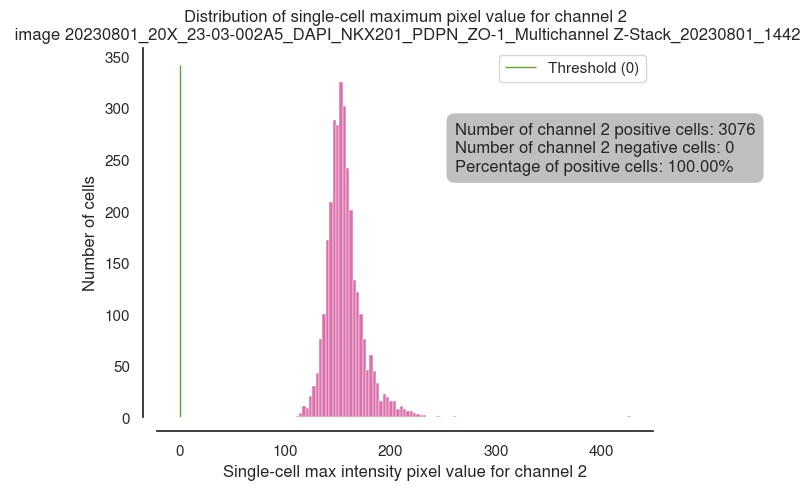

[INFO][2023/11/01 11:13:51 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5...
[INFO][2023/11/01 11:13:51 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:13:51 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:13:51 am] Loading objects/obj_type_2 (36733, 5) (36733 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5']


[INFO][2023/11/01 11:13:51 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


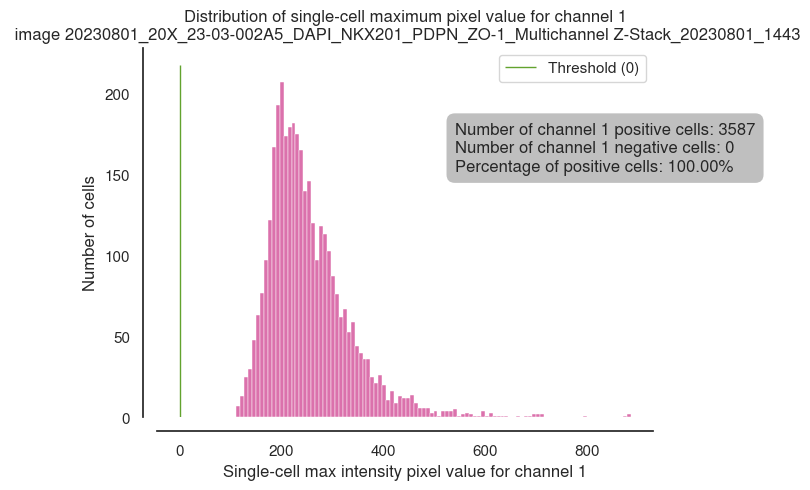

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


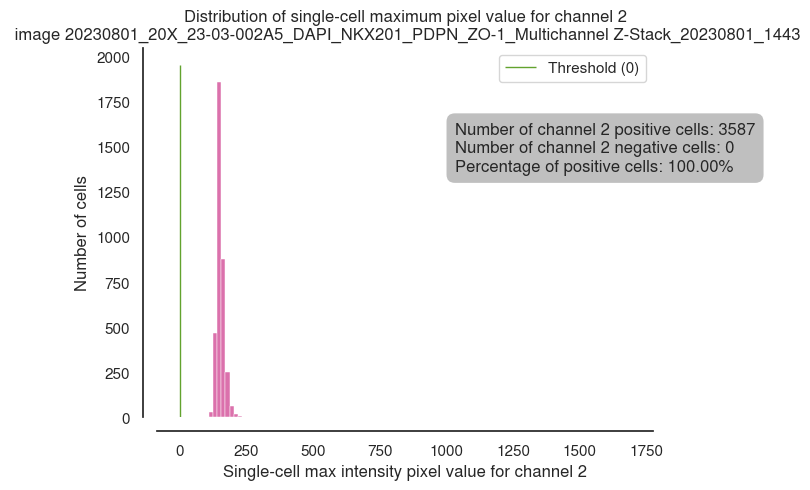

[INFO][2023/11/01 11:13:59 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5...
[INFO][2023/11/01 11:13:59 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:00 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_z_tracks_masks.h5']


[INFO][2023/11/01 11:14:00 am] Loading objects/obj_type_2 (44625, 5) (44625 filtered: None)
[INFO][2023/11/01 11:14:01 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


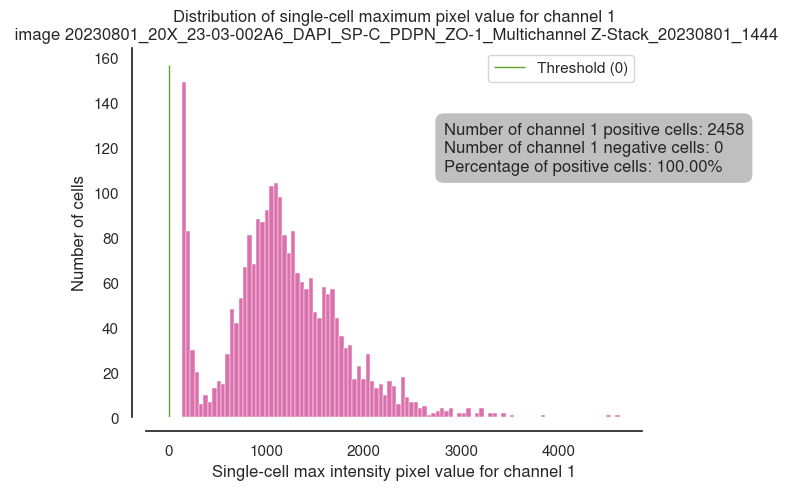

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


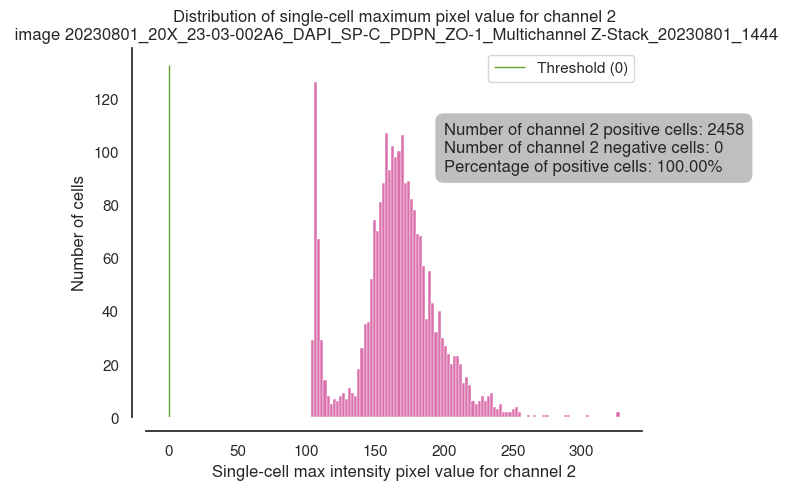

[INFO][2023/11/01 11:14:09 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5...
[INFO][2023/11/01 11:14:09 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:09 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5']


[INFO][2023/11/01 11:14:09 am] Loading objects/obj_type_2 (23179, 5) (23179 filtered: None)
[INFO][2023/11/01 11:14:10 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


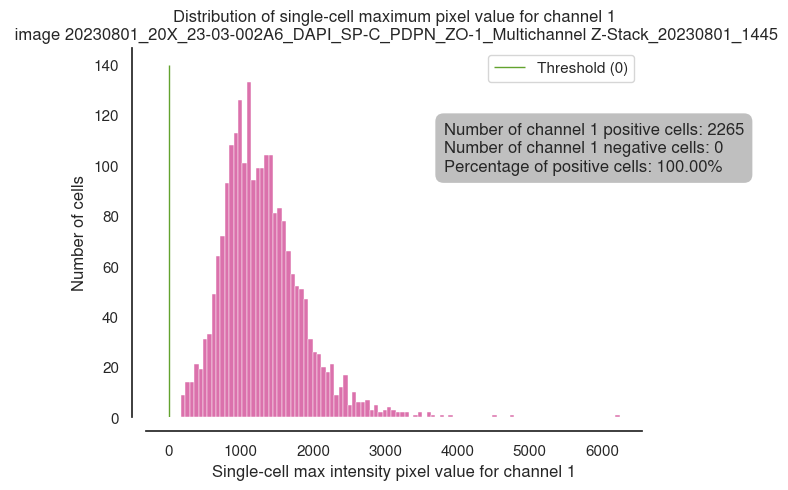

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


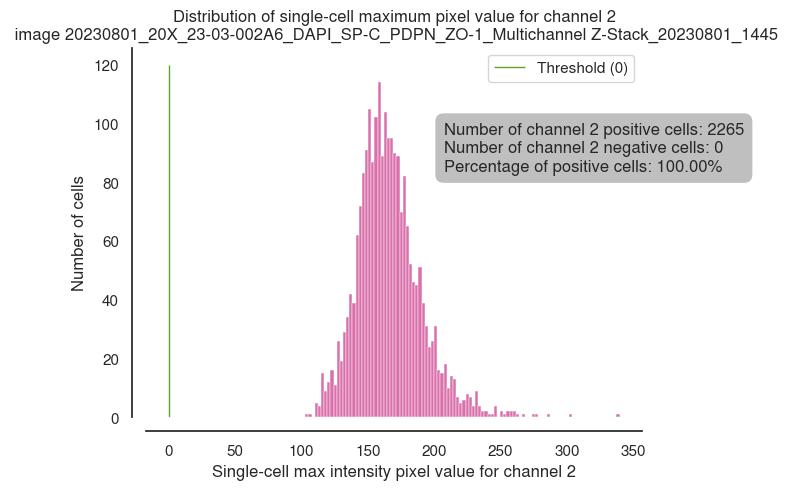

[INFO][2023/11/01 11:14:20 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5...
[INFO][2023/11/01 11:14:20 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:20 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5']


[INFO][2023/11/01 11:14:20 am] Loading objects/obj_type_2 (61201, 5) (61201 filtered: None)
[INFO][2023/11/01 11:14:21 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


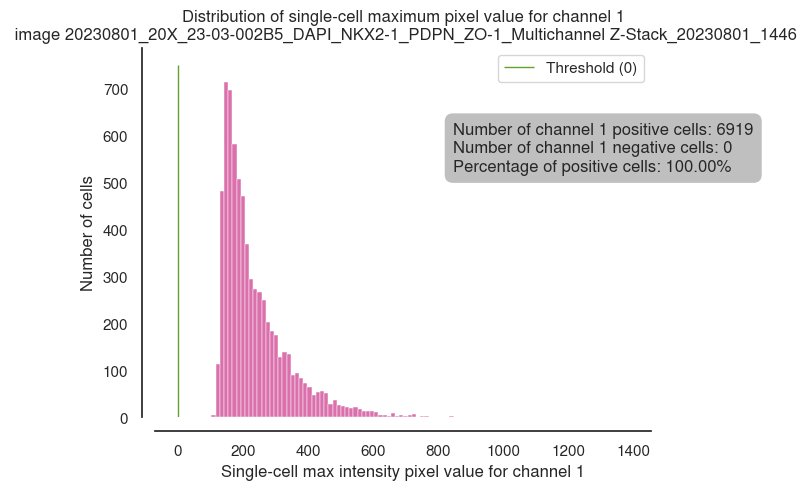

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


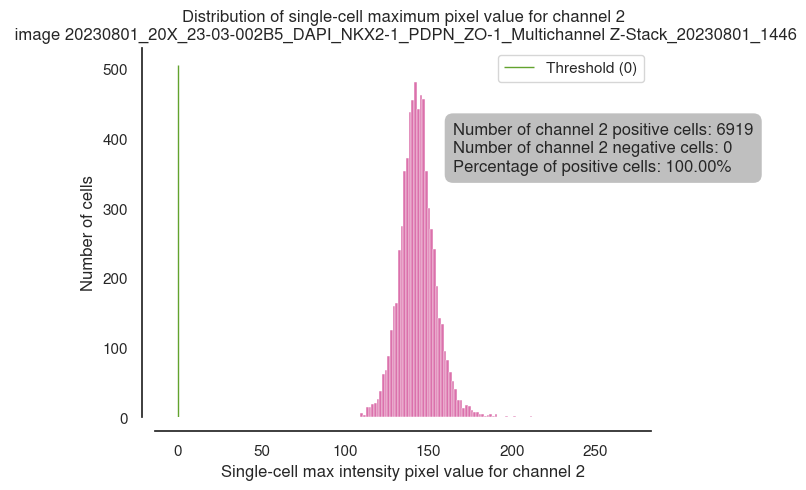

[INFO][2023/11/01 11:14:33 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5...


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5']


[INFO][2023/11/01 11:14:33 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:33 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:14:33 am] Loading objects/obj_type_2 (74603, 5) (74603 filtered: None)
[INFO][2023/11/01 11:14:35 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf 

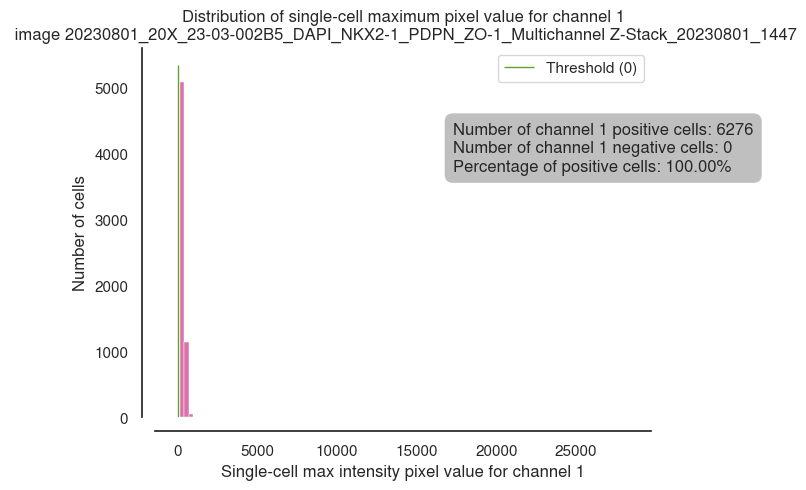

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


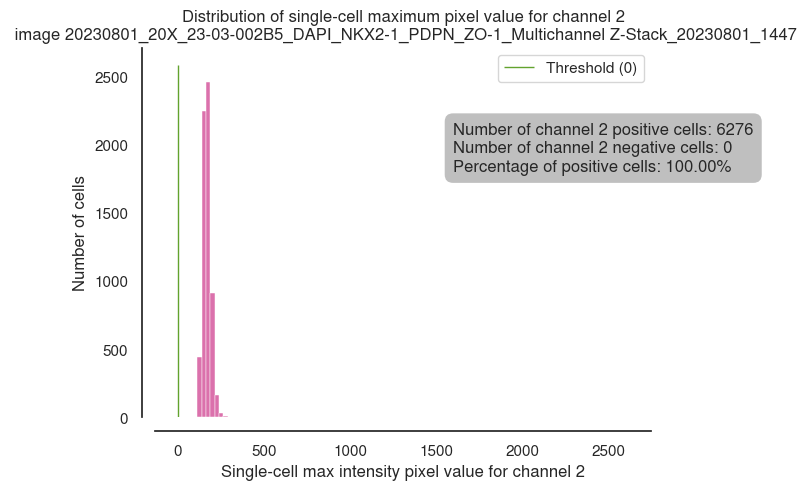

[INFO][2023/11/01 11:14:46 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5...
[INFO][2023/11/01 11:14:47 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:47 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat1.h5']


[INFO][2023/11/01 11:14:47 am] Loading objects/obj_type_2 (72051, 5) (72051 filtered: None)
[INFO][2023/11/01 11:14:48 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


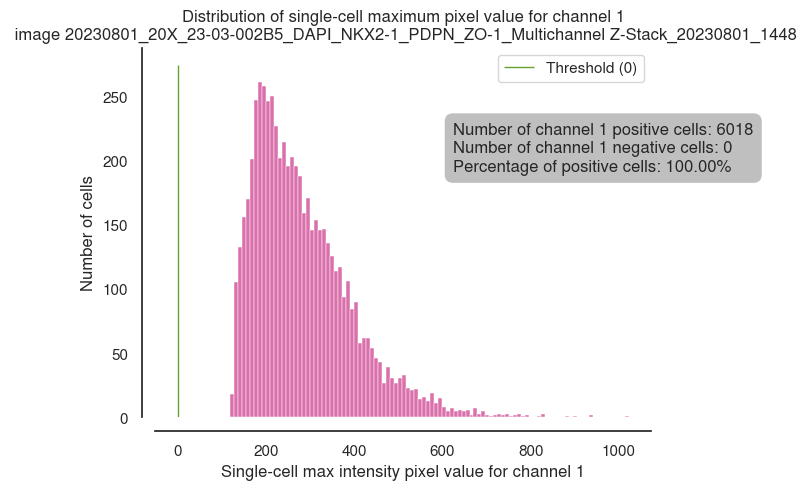

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


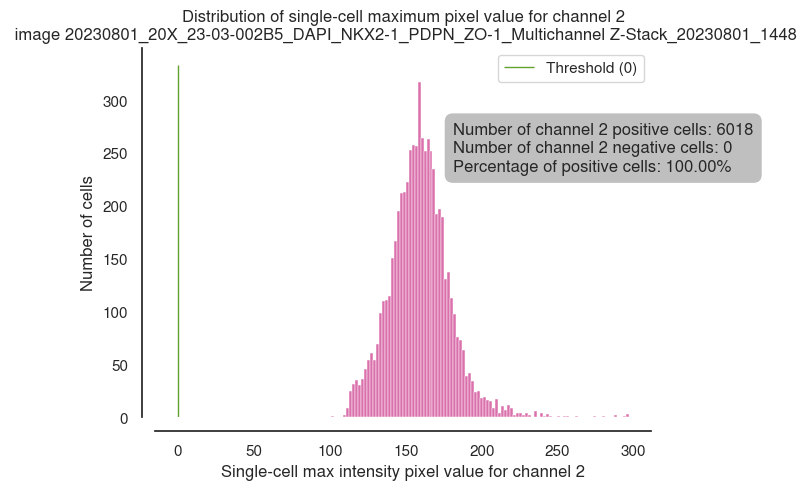

[INFO][2023/11/01 11:14:57 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5...
[INFO][2023/11/01 11:14:58 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:14:58 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5']


[INFO][2023/11/01 11:14:58 am] Loading objects/obj_type_2 (67157, 5) (67157 filtered: None)
[INFO][2023/11/01 11:14:59 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


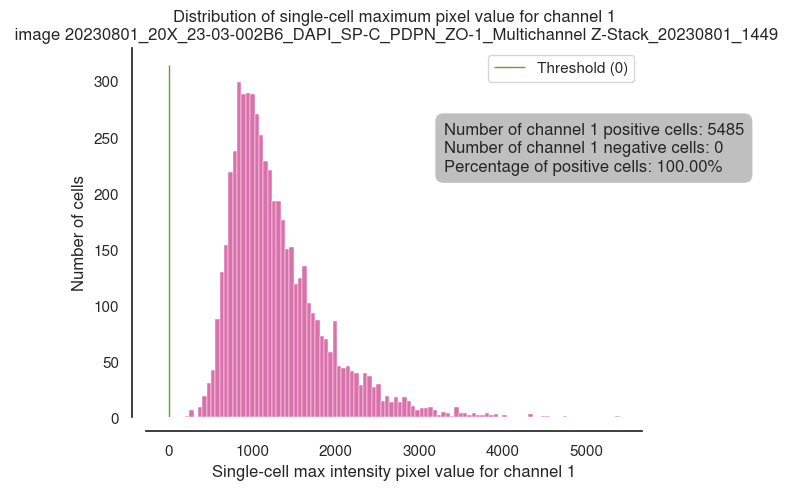

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


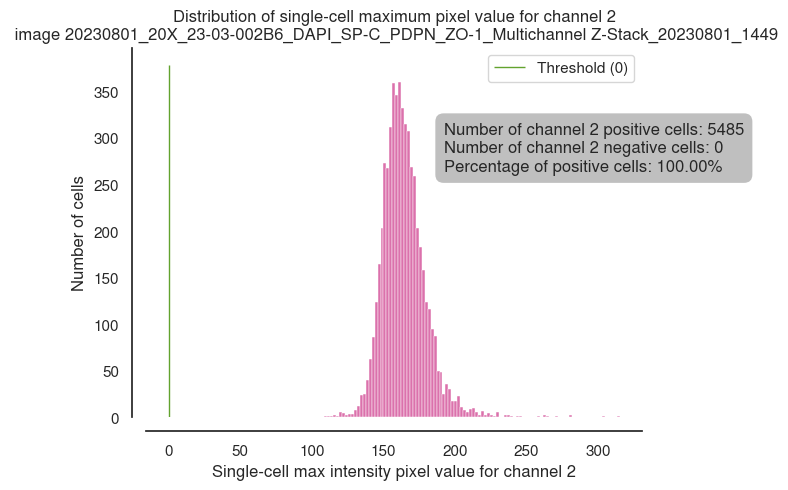

[INFO][2023/11/01 11:15:08 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5...
[INFO][2023/11/01 11:15:08 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:15:08 am] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat1.h5']


[INFO][2023/11/01 11:15:08 am] Loading objects/obj_type_2 (57328, 5) (57328 filtered: None)
[INFO][2023/11/01 11:15:09 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


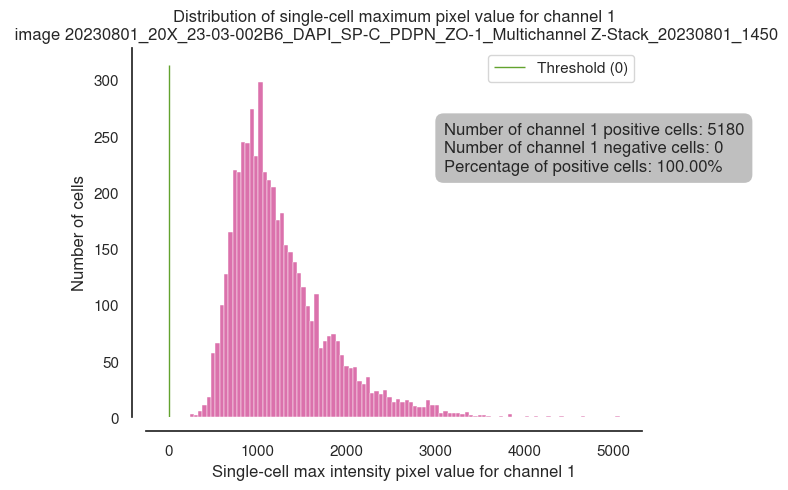

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


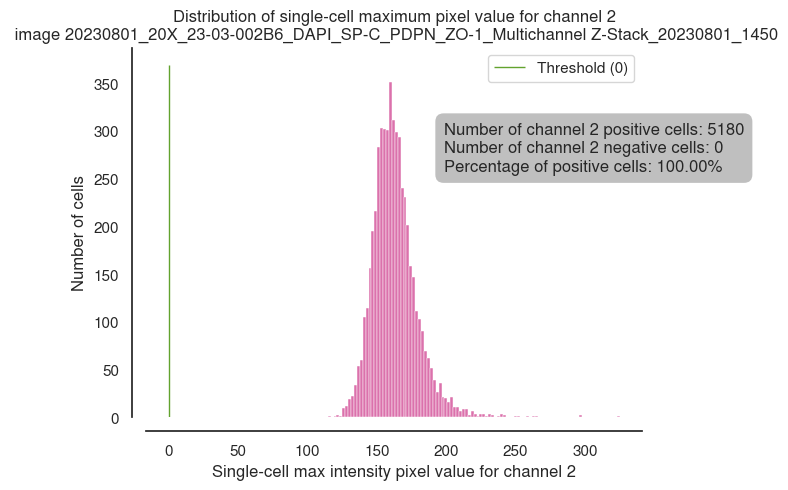

[INFO][2023/11/01 11:15:18 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5...


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat1.h5']


[INFO][2023/11/01 11:15:18 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:15:18 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:15:19 am] Loading objects/obj_type_2 (55719, 5) (55719 filtered: None)
[INFO][2023/11/01 11:15:19 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf valu

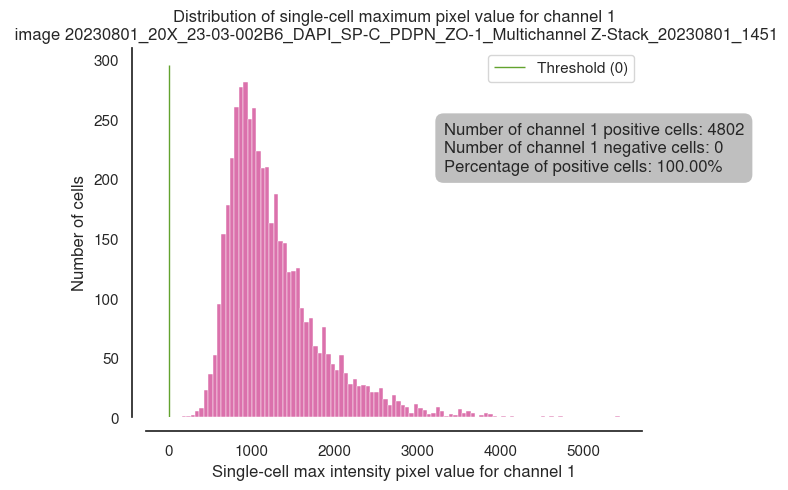

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


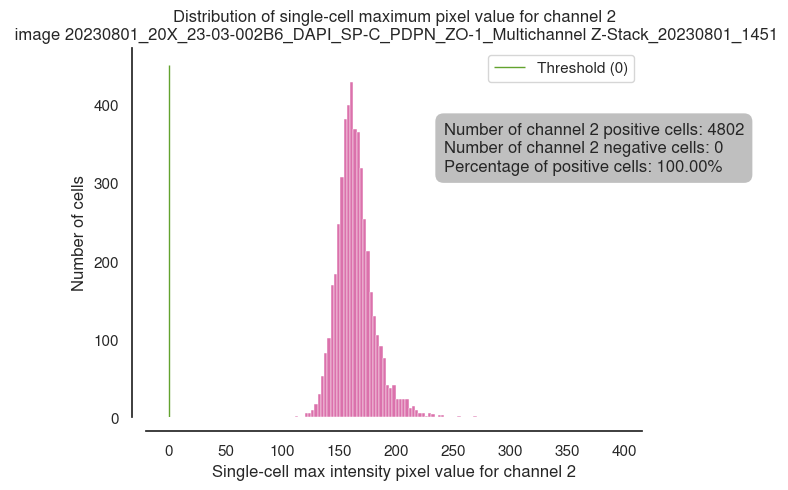

[INFO][2023/11/01 11:15:28 am] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5...
[INFO][2023/11/01 11:15:28 am] Loading tracks/obj_type_2
[INFO][2023/11/01 11:15:28 am] Loading LBEP/obj_type_2
[INFO][2023/11/01 11:15:28 am] Loading objects/obj_type_2 (337, 5) (337 filtered: None)
[INFO][2023/11/01 11:15:28 am] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5']


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


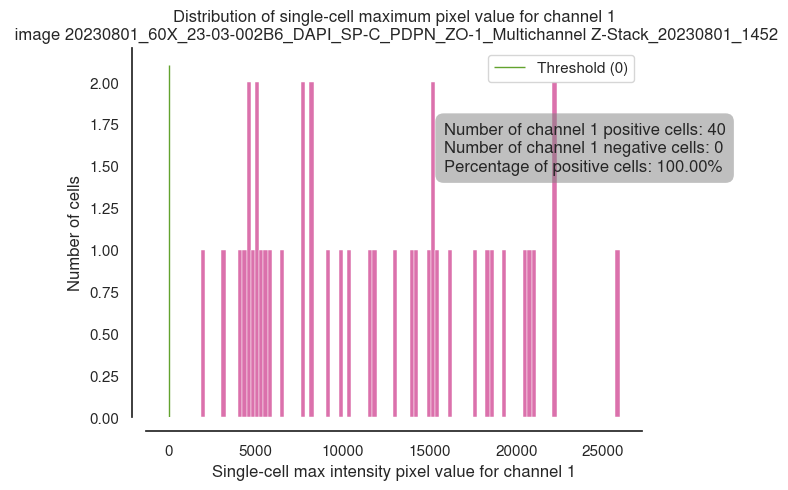

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


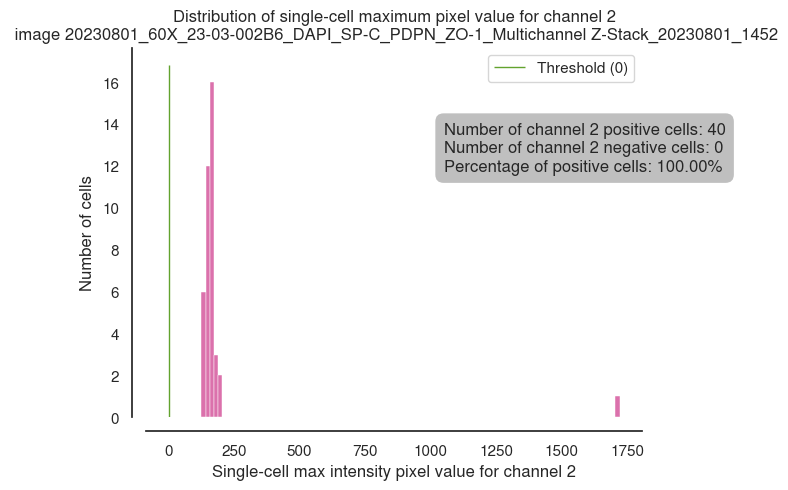

In [477]:
search_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/' # search for image or input basename and dir 

for fn in tqdm(fns, total = len(fns)):
    
    image_base_name = fn+'.tif' #'20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112.tif' 
    img_base_dir = dataio.find_image_directory(search_dir, image_base_name) # img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
    image_fn = os.path.join(img_base_dir, image_base_name)
    image_id = dataio.ID_extractor(image_fn)
    os.path.exists(image_fn)
    
    sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
    sc_fns = glob.glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
    print(sc_fns)
    
    sc_fn = find_filename(sc_fns, "iat2", "z_tracks_masks")
    # Check if the specific file exists, and set sc_fn accordingly, prioritise iat2 fns
    if 'iat2' in sc_fn:
        obj_type = 'obj_type_2'
    elif '_z_tracks_masks' in sc_fn:
        obj_type = 'obj_type_1'
    
    
    with btrack.io.HDF5FileHandler(sc_fn, 
                                       'r', 
                                           obj_type=obj_type#'obj_type_1'#'obj_type_2'
                                       ) as reader:
            # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
            tracks = [t for t in reader.tracks if len(t) >= 3] #reader.tracks #
            # segmentation = reader.segmentation
    # napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
    # recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks)
    output_dir = os.path.dirname(sc_fn)
    
    # for channel in [1,2]:# Example usage:
    otsu = False
    save = False #True
    channel = 1
    # intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
    # intensities_array = np.array(intensities)
    threshold = 0# int(calculate_otsu_threshold(intensities_array))
    # Example usage:
    plot_single_cell_intensities(tracks, channel, threshold, image_fn, save = save, otsu = otsu)
    
    # channel = 2
    # # intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
    # # intensities_array = np.array(intensities)
    # threshold = 0#int(calculate_otsu_threshold(intensities_array))
    # # Example usage:
    # plot_single_cell_intensities(tracks, channel, threshold, image_fn, 
    #                              # range = (0,5000),
    #                              save = save, otsu = otsu, 
    #                             remove_outliers=False) 

  0%|          | 0/36 [00:00<?, ?it/s]

[INFO][2023/11/01 12:13:08 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5...
[INFO][2023/11/01 12:13:08 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:13:08 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:13:08 pm] Loading objects/obj_type_2 (27786, 5) (27786 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_z_tracks_masks.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5']


[INFO][2023/11/01 12:13:09 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


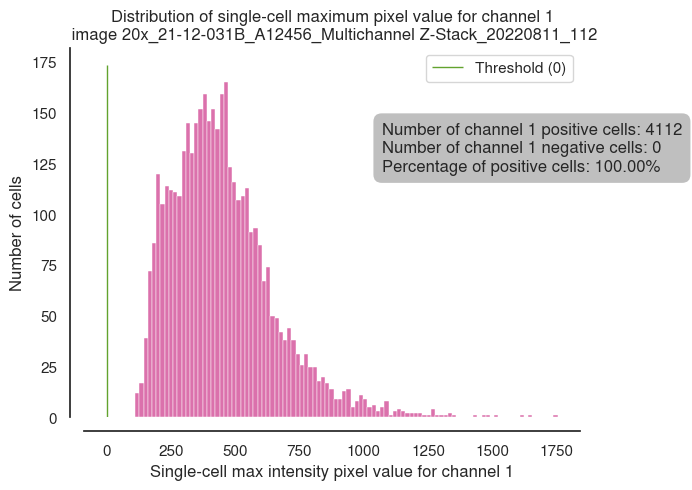

[INFO][2023/11/01 12:13:18 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5...
[INFO][2023/11/01 12:13:18 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:13:18 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:13:19 pm] Loading objects/obj_type_1 (44449, 5) (44449 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5']


[INFO][2023/11/01 12:13:19 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


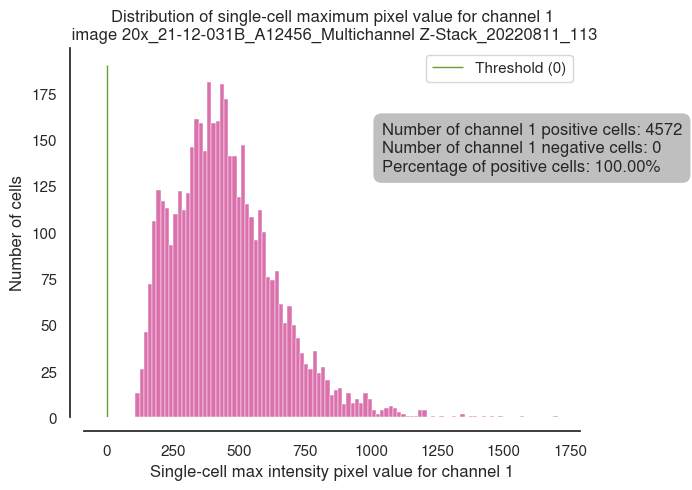

[INFO][2023/11/01 12:13:29 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5...
[INFO][2023/11/01 12:13:29 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:13:29 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:13:29 pm] Loading objects/obj_type_2 (23232, 5) (23232 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5']


[INFO][2023/11/01 12:13:30 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_114_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


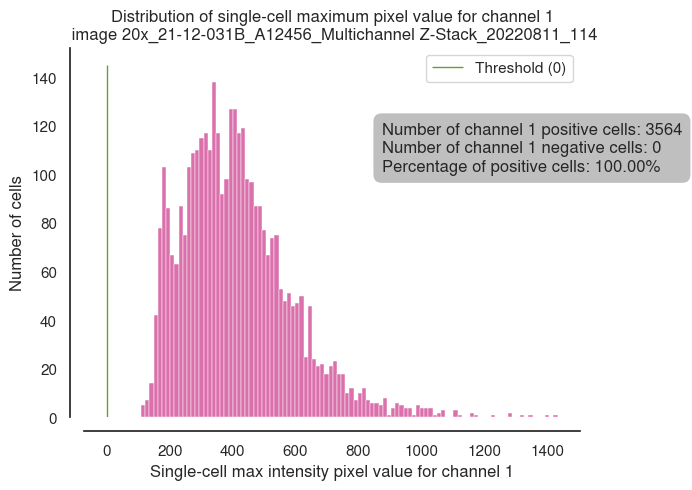

[INFO][2023/11/01 12:13:37 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5...
[INFO][2023/11/01 12:13:37 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:13:37 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:13:37 pm] Loading objects/obj_type_1 (53982, 5) (53982 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5']


[INFO][2023/11/01 12:13:39 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_121_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


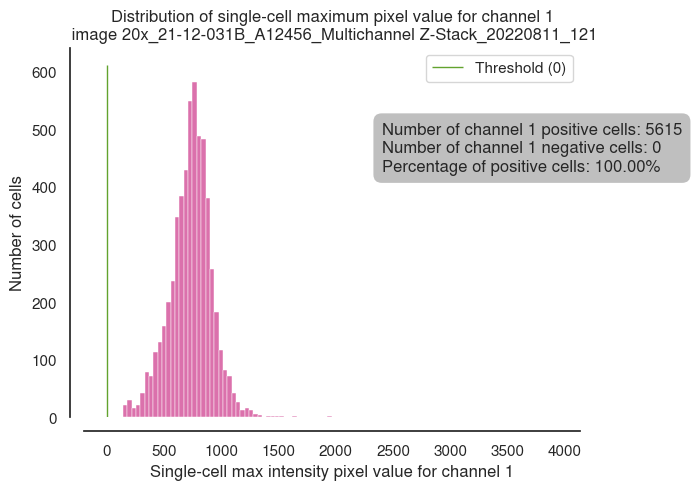

[INFO][2023/11/01 12:13:46 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5...
[INFO][2023/11/01 12:13:46 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:13:46 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5']


[INFO][2023/11/01 12:13:47 pm] Loading objects/obj_type_1 (57959, 5) (57959 filtered: None)
[INFO][2023/11/01 12:13:47 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_122_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


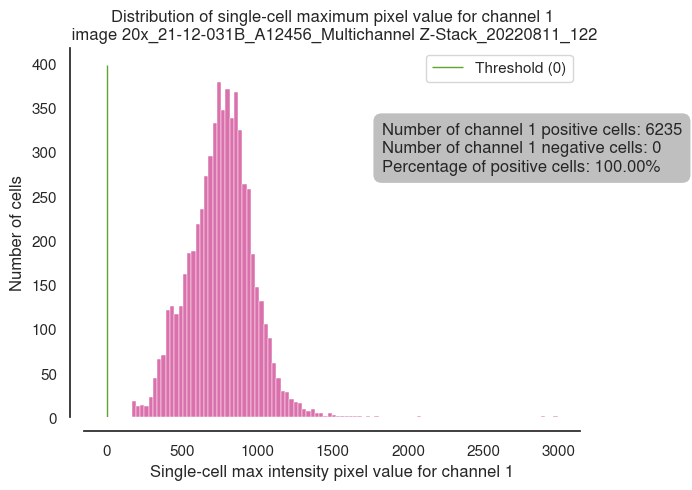

[INFO][2023/11/01 12:13:55 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5...
[INFO][2023/11/01 12:13:55 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:13:55 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:13:55 pm] Loading objects/obj_type_1 (54676, 5) (54676 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5']


[INFO][2023/11/01 12:13:56 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_123_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


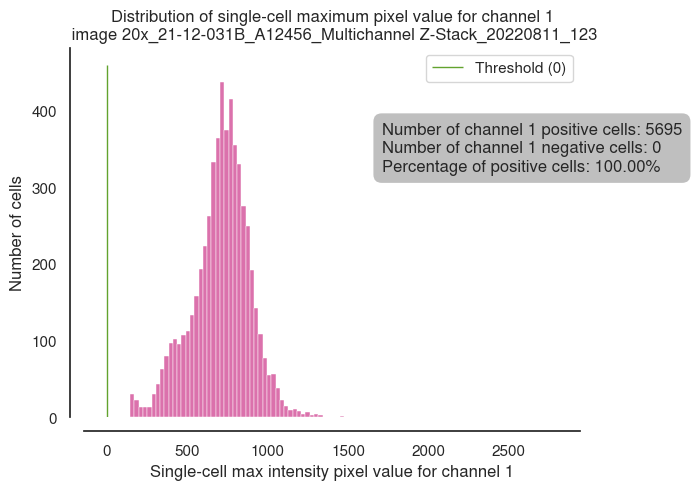

[INFO][2023/11/01 12:14:04 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5...
[INFO][2023/11/01 12:14:04 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:14:04 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5']


[INFO][2023/11/01 12:14:04 pm] Loading objects/obj_type_1 (75007, 5) (75007 filtered: None)
[INFO][2023/11/01 12:14:06 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_194_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


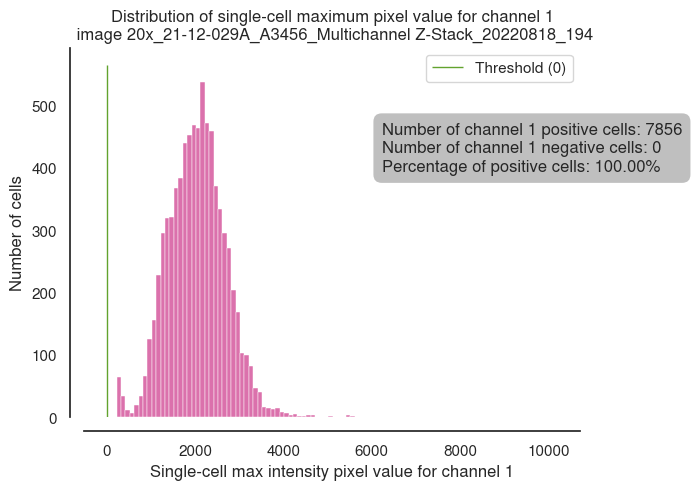

[INFO][2023/11/01 12:14:13 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5...
[INFO][2023/11/01 12:14:14 pm] Loading tracks/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5']


[INFO][2023/11/01 12:14:14 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:14:14 pm] Loading objects/obj_type_1 (71466, 5) (71466 filtered: None)
[INFO][2023/11/01 12:14:15 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_195_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_i

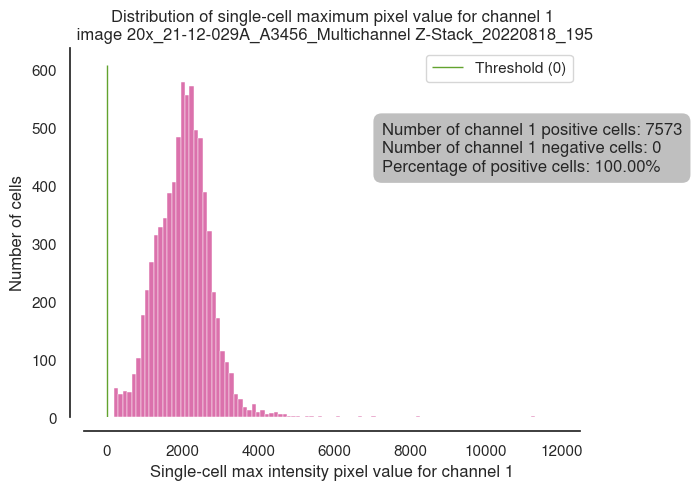

[INFO][2023/11/01 12:14:22 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5...
[INFO][2023/11/01 12:14:23 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:14:23 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5']


[INFO][2023/11/01 12:14:23 pm] Loading objects/obj_type_1 (68006, 5) (68006 filtered: None)
[INFO][2023/11/01 12:14:24 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-029A_A3456_Multichannel Z-Stack_20220818_196_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


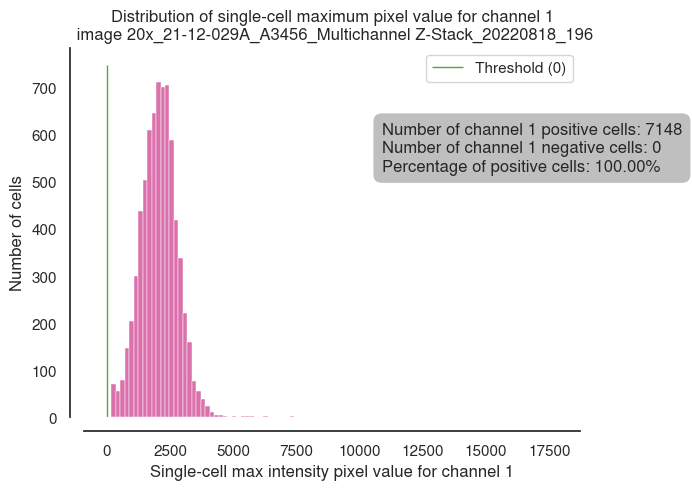

[INFO][2023/11/01 12:14:34 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5...
[INFO][2023/11/01 12:14:34 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:14:34 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5']


[INFO][2023/11/01 12:14:34 pm] Loading objects/obj_type_1 (41128, 5) (41128 filtered: None)
[INFO][2023/11/01 12:14:35 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_235_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


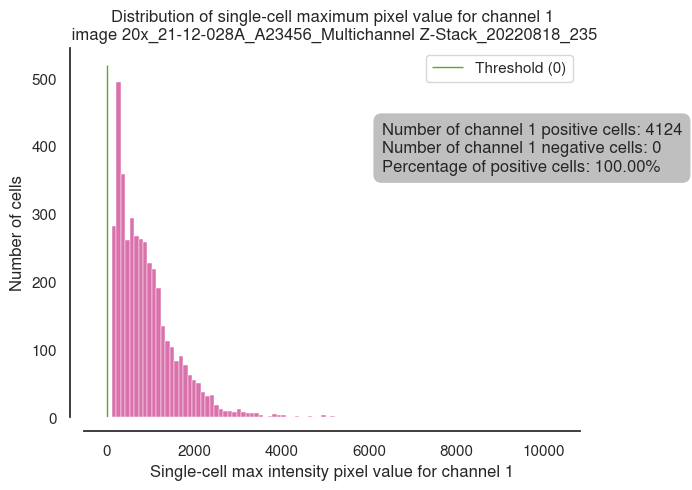

[INFO][2023/11/01 12:14:45 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5...
[INFO][2023/11/01 12:14:45 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:14:45 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5']


[INFO][2023/11/01 12:14:45 pm] Loading objects/obj_type_1 (44416, 5) (44416 filtered: None)
[INFO][2023/11/01 12:14:46 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_236_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


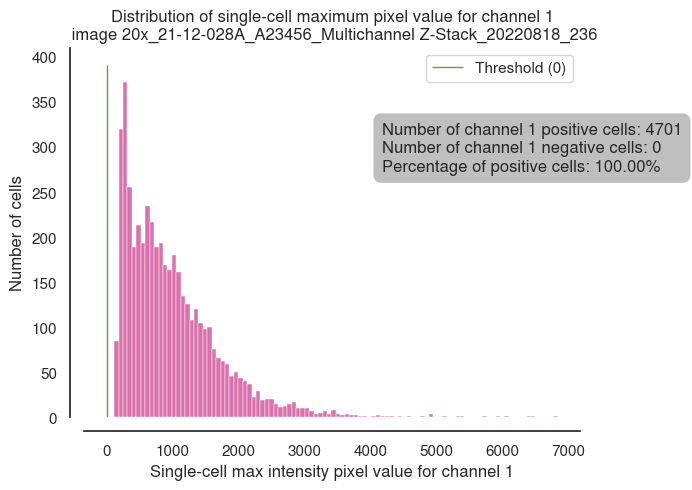

[INFO][2023/11/01 12:14:56 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5...
[INFO][2023/11/01 12:14:56 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:14:56 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:14:56 pm] Loading objects/obj_type_2 (28241, 5) (28241 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5']


[INFO][2023/11/01 12:14:57 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_237_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


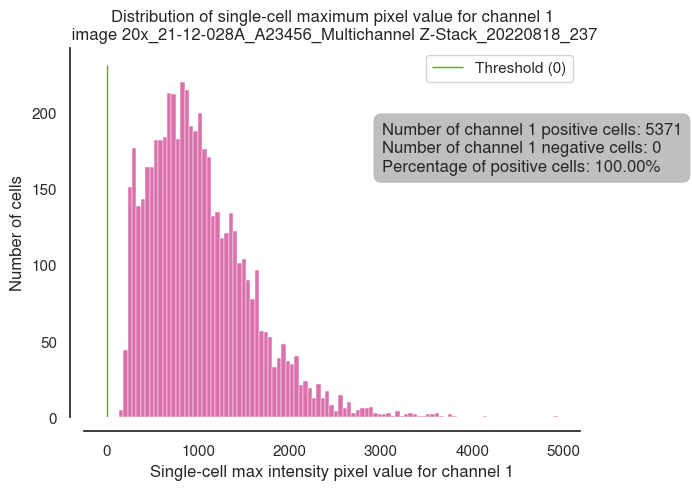

[INFO][2023/11/01 12:15:04 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:04 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:04 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:15:04 pm] Loading objects/obj_type_1 (54625, 5) (54625 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:05 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_244_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


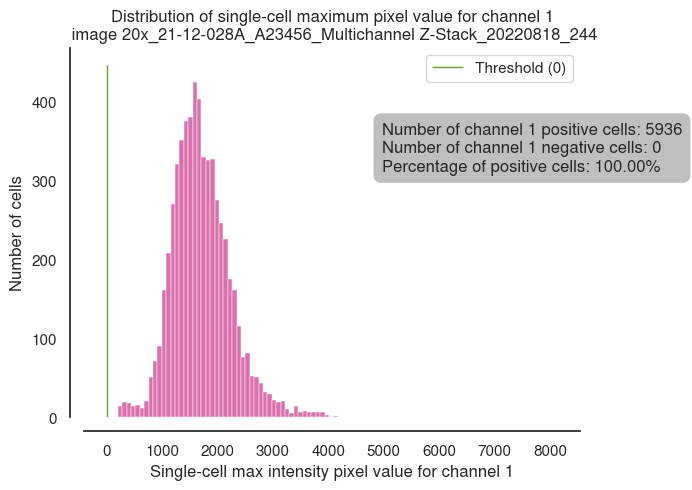

[INFO][2023/11/01 12:15:13 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:13 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:13 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:13 pm] Loading objects/obj_type_1 (53979, 5) (53979 filtered: None)
[INFO][2023/11/01 12:15:15 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_245_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


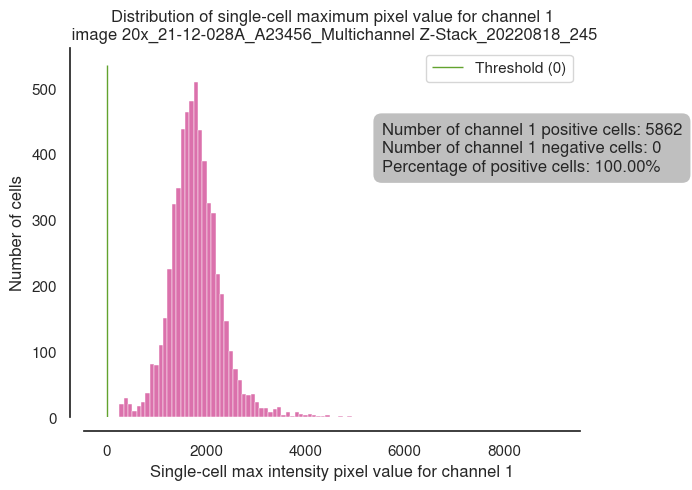

[INFO][2023/11/01 12:15:22 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:22 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:22 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:22 pm] Loading objects/obj_type_1 (52314, 5) (52314 filtered: None)
[INFO][2023/11/01 12:15:23 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_246_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


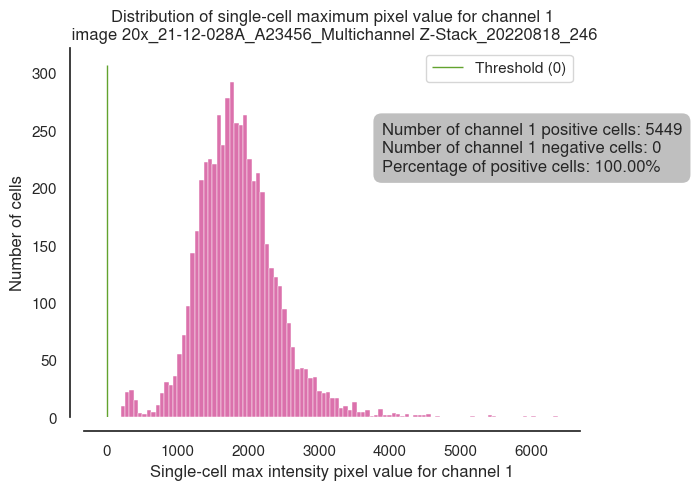

[INFO][2023/11/01 12:15:33 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:33 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:33 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:15:33 pm] Loading objects/obj_type_1 (11889, 5) (11889 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:33 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_284_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


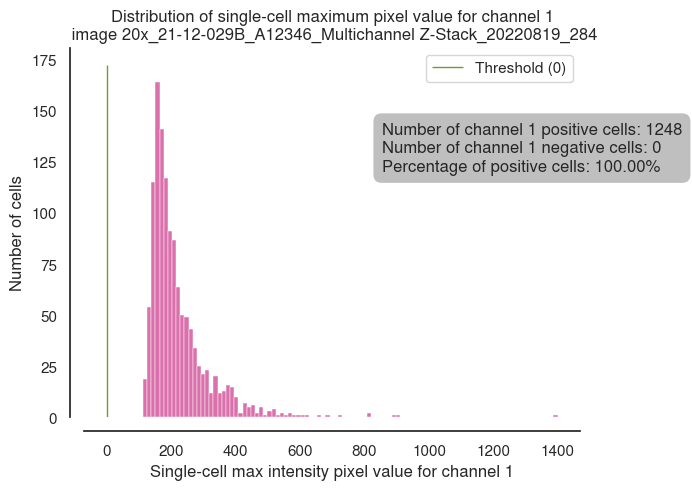

[INFO][2023/11/01 12:15:44 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:44 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:44 pm] Loading LBEP/obj_type_1
[INFO][2023/11/01 12:15:44 pm] Loading objects/obj_type_1 (38518, 5) (38518 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:45 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_286_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


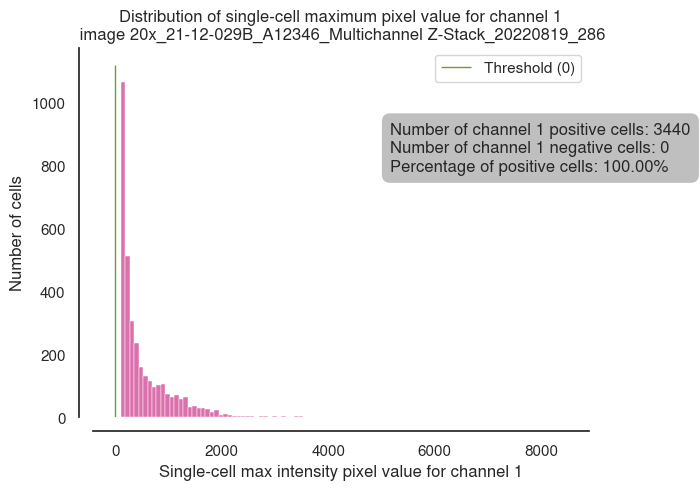

[INFO][2023/11/01 12:15:56 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5...
[INFO][2023/11/01 12:15:56 pm] Loading tracks/obj_type_1
[INFO][2023/11/01 12:15:56 pm] Loading LBEP/obj_type_1


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5']


[INFO][2023/11/01 12:15:56 pm] Loading objects/obj_type_1 (50455, 5) (50455 filtered: None)
[INFO][2023/11/01 12:15:57 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20x_21-12-029B_A12346_Multichannel Z-Stack_20220819_287_z_tracks_masks.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


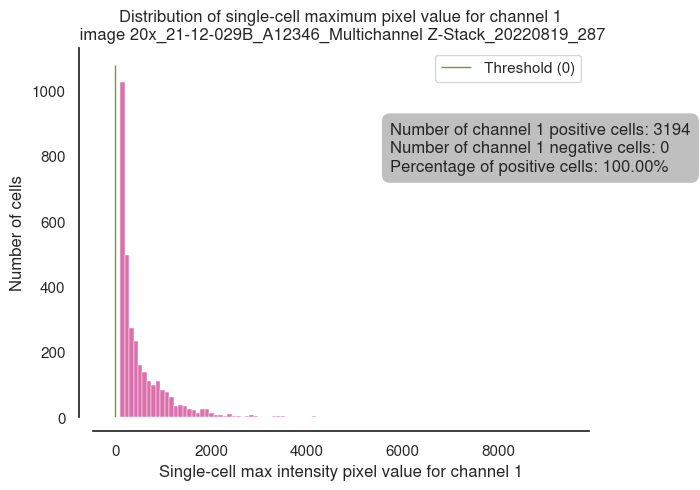

[INFO][2023/11/01 12:16:07 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5...
[INFO][2023/11/01 12:16:08 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:08 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:16:08 pm] Loading objects/obj_type_2 (52662, 5) (52662 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_z_tracks_masks.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5']


[INFO][2023/11/01 12:16:09 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1434_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


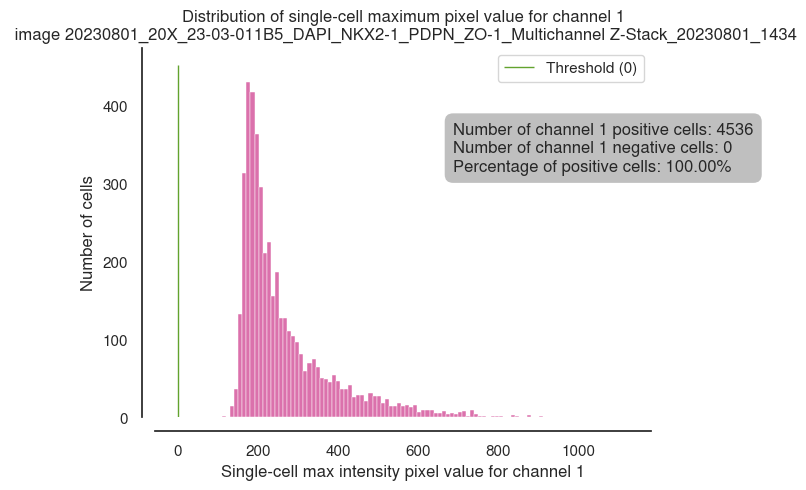

[INFO][2023/11/01 12:16:19 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5...
[INFO][2023/11/01 12:16:20 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:20 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:16:20 pm] Loading objects/obj_type_2 (50760, 5) (50760 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5']


[INFO][2023/11/01 12:16:20 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1435_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


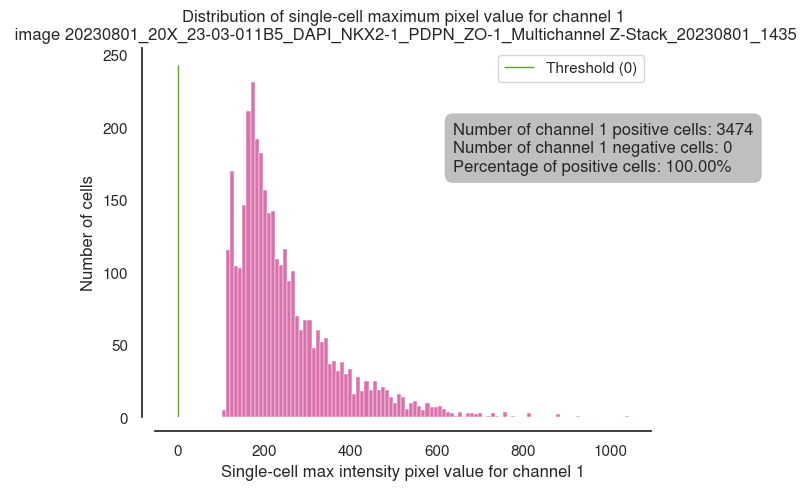

[INFO][2023/11/01 12:16:30 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5...
[INFO][2023/11/01 12:16:31 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:31 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5']


[INFO][2023/11/01 12:16:31 pm] Loading objects/obj_type_2 (55607, 5) (55607 filtered: None)
[INFO][2023/11/01 12:16:32 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1436_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


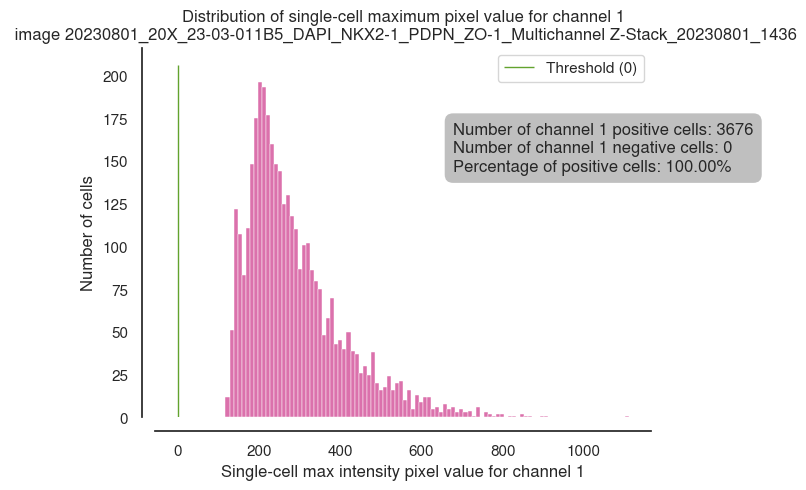

[INFO][2023/11/01 12:16:40 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5...
[INFO][2023/11/01 12:16:40 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:40 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:16:40 pm] Loading objects/obj_type_2 (51277, 5) (51277 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat1.h5']


[INFO][2023/11/01 12:16:41 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1438_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


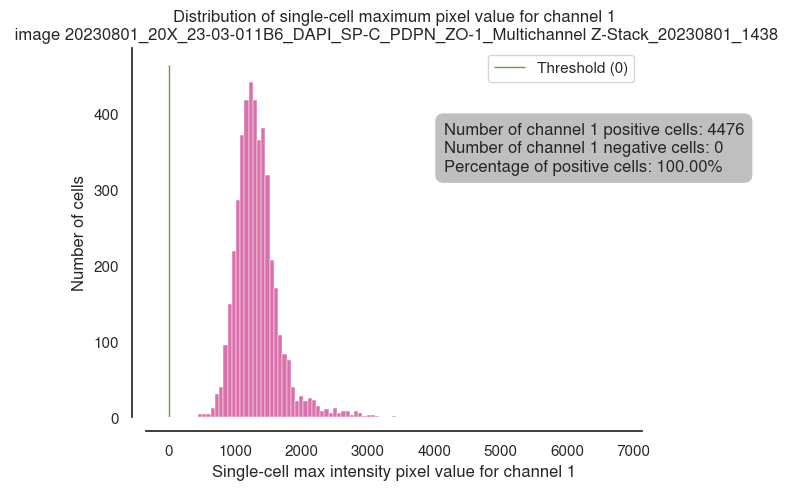

[INFO][2023/11/01 12:16:48 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5...
[INFO][2023/11/01 12:16:48 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:48 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5']


[INFO][2023/11/01 12:16:48 pm] Loading objects/obj_type_2 (45921, 5) (45921 filtered: None)
[INFO][2023/11/01 12:16:49 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1439_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


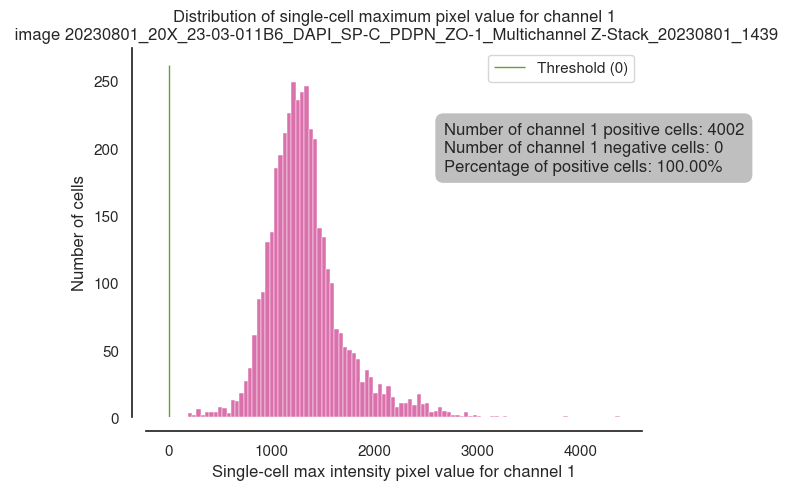

[INFO][2023/11/01 12:16:57 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5...
[INFO][2023/11/01 12:16:57 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:16:57 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:16:57 pm] Loading objects/obj_type_2 (37477, 5) (37477 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat1.h5']


[INFO][2023/11/01 12:16:58 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-011B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1440_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


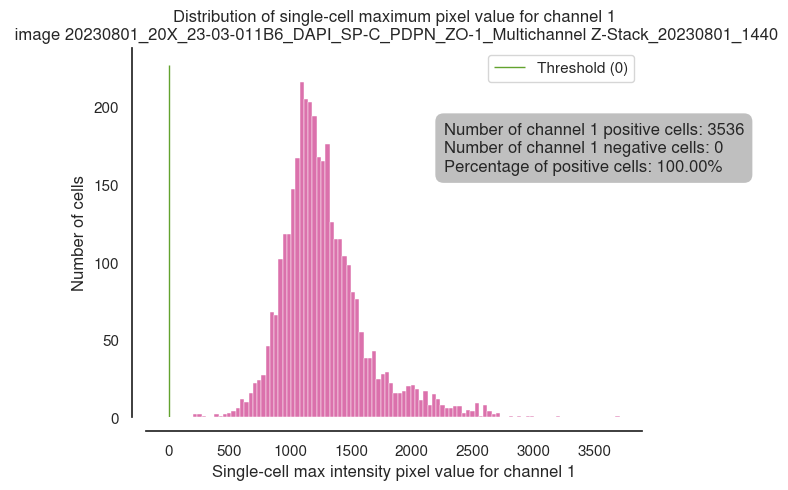

[INFO][2023/11/01 12:17:08 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5...
[INFO][2023/11/01 12:17:08 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:08 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:17:08 pm] Loading objects/obj_type_2 (49364, 5) (49364 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_z_tracks_masks.h5']


[INFO][2023/11/01 12:17:09 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1441_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


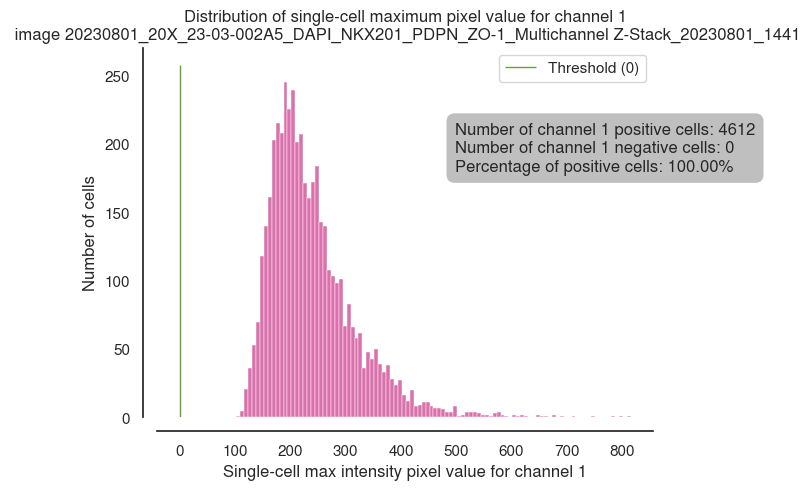

[INFO][2023/11/01 12:17:20 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5...
[INFO][2023/11/01 12:17:20 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:20 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:17:20 pm] Loading objects/obj_type_2 (30775, 5) (30775 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5']


[INFO][2023/11/01 12:17:21 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1442_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


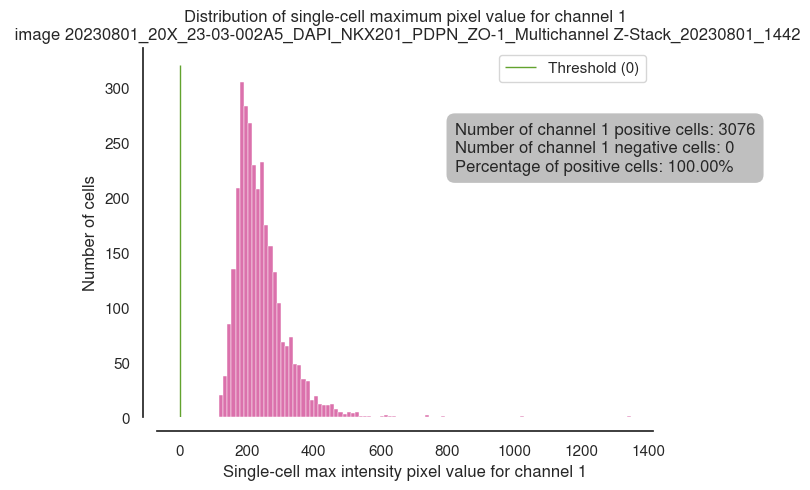

[INFO][2023/11/01 12:17:31 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5...
[INFO][2023/11/01 12:17:31 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:31 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5']


[INFO][2023/11/01 12:17:31 pm] Loading objects/obj_type_2 (36733, 5) (36733 filtered: None)
[INFO][2023/11/01 12:17:32 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A5_DAPI_NKX201_PDPN_ZO-1_Multichannel Z-Stack_20230801_1443_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


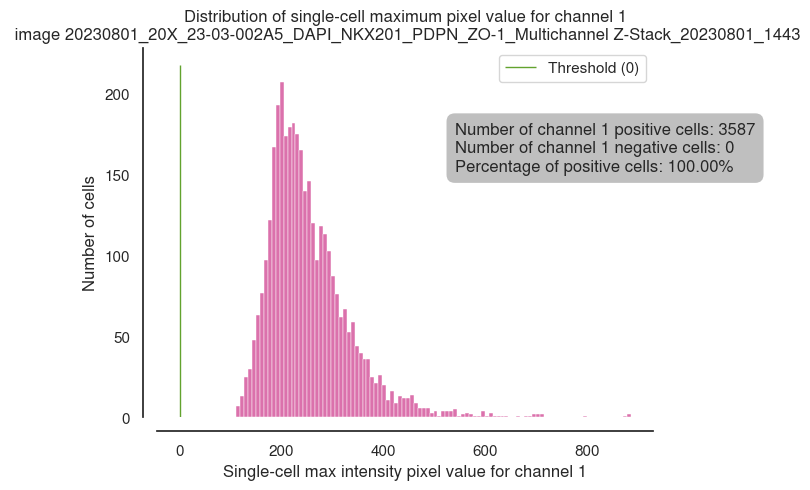

[INFO][2023/11/01 12:17:41 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5...
[INFO][2023/11/01 12:17:41 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:41 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_sc_data.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_z_tracks_masks.h5']


[INFO][2023/11/01 12:17:41 pm] Loading objects/obj_type_2 (44625, 5) (44625 filtered: None)
[INFO][2023/11/01 12:17:42 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1444_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


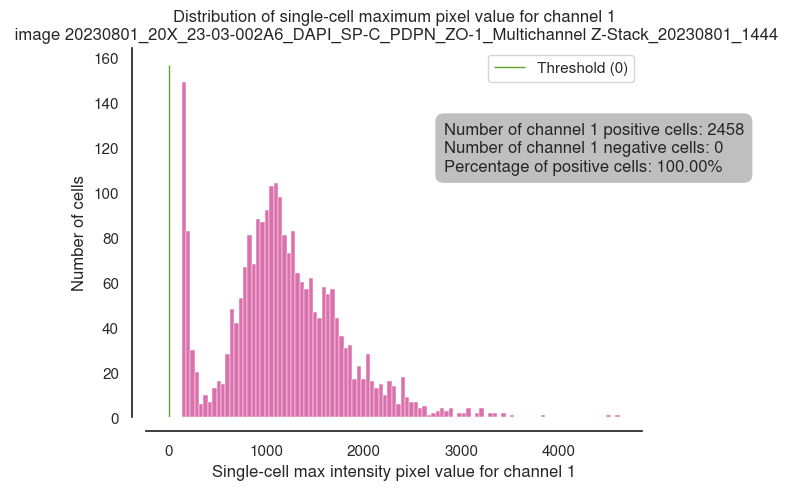

[INFO][2023/11/01 12:17:49 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5...
[INFO][2023/11/01 12:17:49 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:49 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:17:49 pm] Loading objects/obj_type_2 (23179, 5) (23179 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5']


[INFO][2023/11/01 12:17:50 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002A6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1445_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


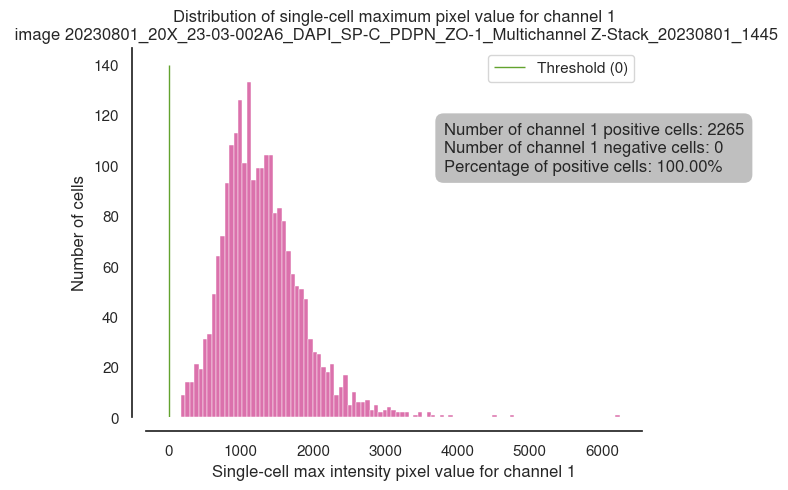

[INFO][2023/11/01 12:17:59 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5...
[INFO][2023/11/01 12:17:59 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:17:59 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5']


[INFO][2023/11/01 12:18:00 pm] Loading objects/obj_type_2 (61201, 5) (61201 filtered: None)
[INFO][2023/11/01 12:18:01 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1446_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


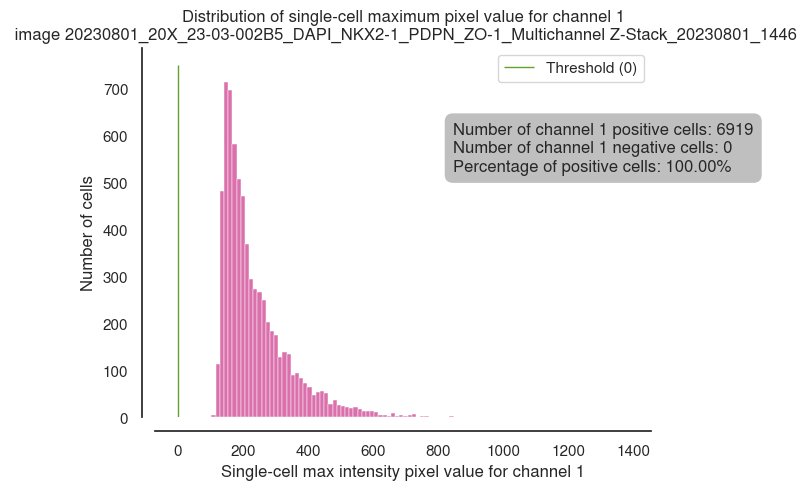

[INFO][2023/11/01 12:18:11 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5...
[INFO][2023/11/01 12:18:11 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:18:11 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5']


[INFO][2023/11/01 12:18:12 pm] Loading objects/obj_type_2 (74603, 5) (74603 filtered: None)
[INFO][2023/11/01 12:18:13 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1447_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


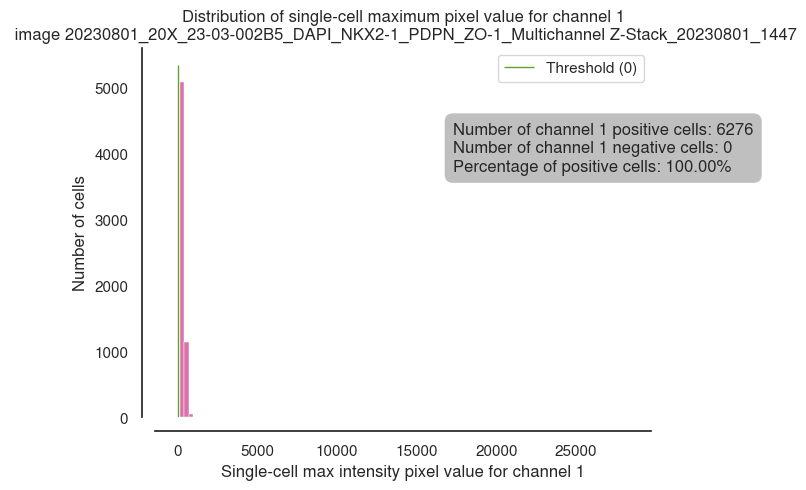

[INFO][2023/11/01 12:18:23 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5...
[INFO][2023/11/01 12:18:23 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:18:23 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat1.h5']


[INFO][2023/11/01 12:18:23 pm] Loading objects/obj_type_2 (72051, 5) (72051 filtered: None)
[INFO][2023/11/01 12:18:25 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B5_DAPI_NKX2-1_PDPN_ZO-1_Multichannel Z-Stack_20230801_1448_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


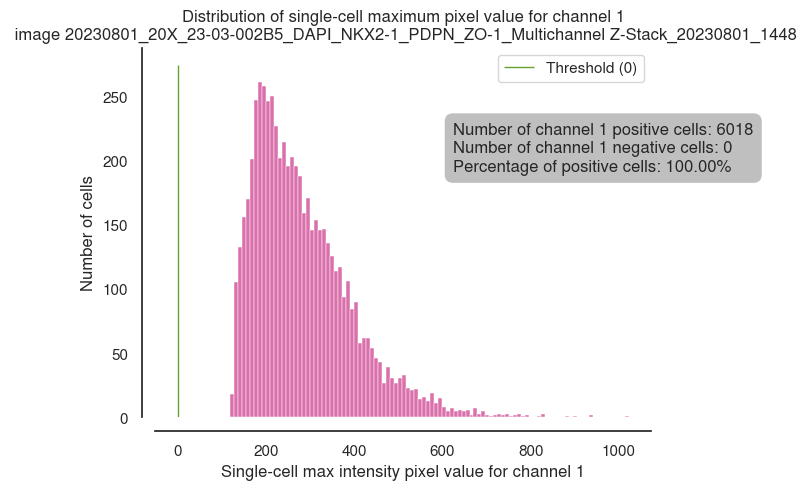

[INFO][2023/11/01 12:18:34 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5...
[INFO][2023/11/01 12:18:34 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:18:34 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5']


[INFO][2023/11/01 12:18:34 pm] Loading objects/obj_type_2 (67157, 5) (67157 filtered: None)
[INFO][2023/11/01 12:18:35 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1449_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


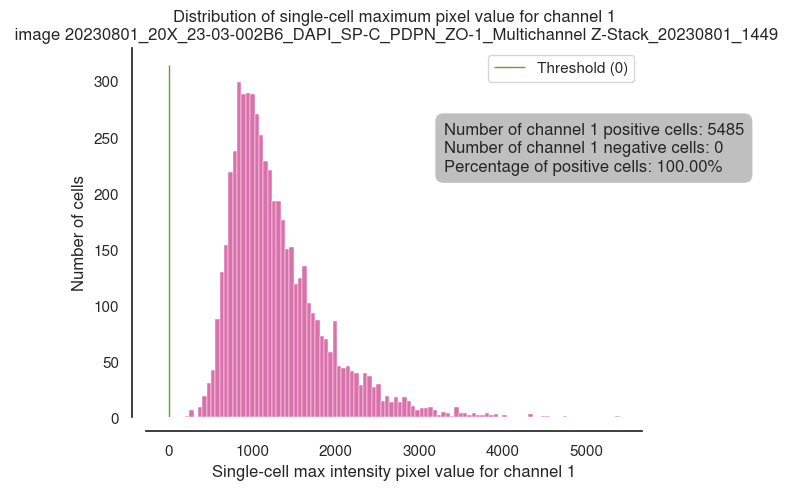

[INFO][2023/11/01 12:18:43 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5...
[INFO][2023/11/01 12:18:43 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:18:43 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:18:43 pm] Loading objects/obj_type_2 (57328, 5) (57328 filtered: None)


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat1.h5']


[INFO][2023/11/01 12:18:45 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1450_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


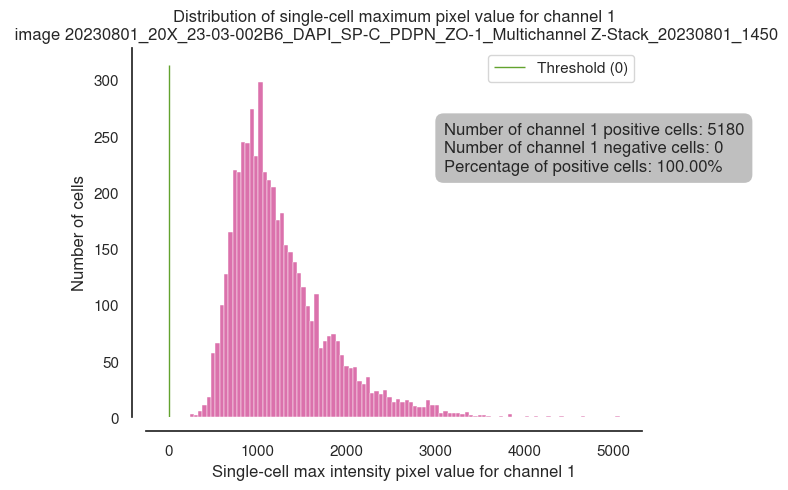

[INFO][2023/11/01 12:18:53 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5...
[INFO][2023/11/01 12:18:53 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:18:53 pm] Loading LBEP/obj_type_2


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat1.h5']


[INFO][2023/11/01 12:18:53 pm] Loading objects/obj_type_2 (55719, 5) (55719 filtered: None)
[INFO][2023/11/01 12:18:54 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_20X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1451_iat2.h5
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


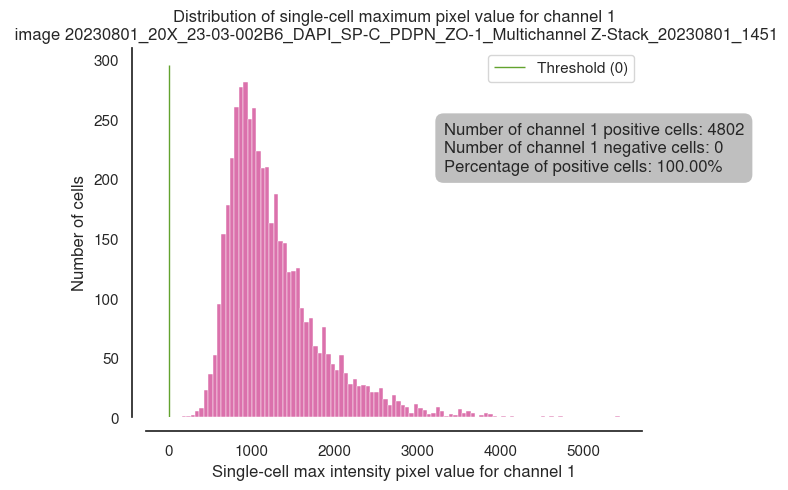

[INFO][2023/11/01 12:19:02 pm] Opening HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5...
[INFO][2023/11/01 12:19:02 pm] Loading tracks/obj_type_2
[INFO][2023/11/01 12:19:02 pm] Loading LBEP/obj_type_2
[INFO][2023/11/01 12:19:02 pm] Loading objects/obj_type_2 (337, 5) (337 filtered: None)
[INFO][2023/11/01 12:19:02 pm] Closing HDF file: /run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5


['/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat1.h5', '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_SPC_PDPN_ZO1/sc_analyses/20230801_60X_23-03-002B6_DAPI_SP-C_PDPN_ZO-1_Multichannel Z-Stack_20230801_1452_iat2.h5']


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


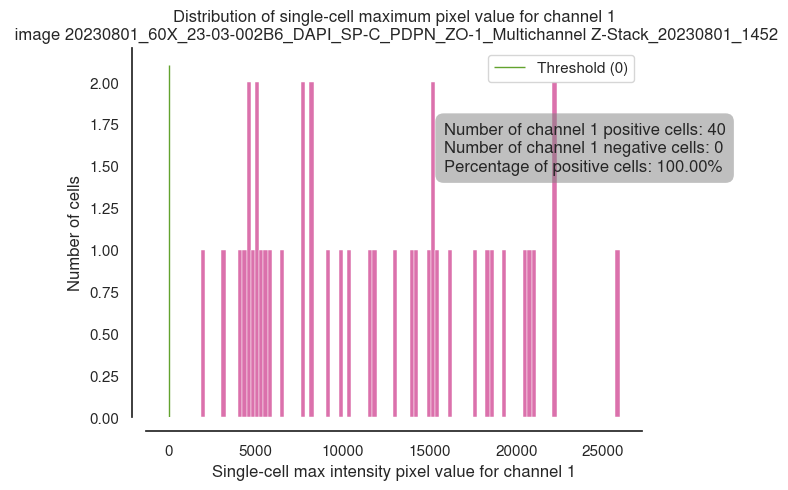

In [478]:
search_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/' # search for image or input basename and dir 

for fn in tqdm(fns, total = len(fns)):
    
    image_base_name = fn+'.tif' #'20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_112.tif' 
    img_base_dir = dataio.find_image_directory(search_dir, image_base_name) # img_base_dir = '/run/user/30046150/gvfs/smb-share:server=data2.thecrick.org,share=lab-gutierrezm/home/shared/Lung on Chip/homuncu_loc_image_analysis/iAT1_iAT2_experiments/DAPI_NKX21_PDPN_ZO1/images'
    image_fn = os.path.join(img_base_dir, image_base_name)
    image_id = dataio.ID_extractor(image_fn)
    os.path.exists(image_fn)
    
    sc_base_dir = img_base_dir.replace('images', 'sc_analyses') 
    sc_fns = glob.glob(os.path.join(sc_base_dir, f'*_{image_id}*.h5'))
    print(sc_fns)
    
    sc_fn = find_filename(sc_fns, "iat2", "z_tracks_masks")
    # Check if the specific file exists, and set sc_fn accordingly, prioritise iat2 fns
    if 'iat2' in sc_fn:
        obj_type = 'obj_type_2'
    elif '_z_tracks_masks' in sc_fn:
        obj_type = 'obj_type_1'
    
    
    with btrack.io.HDF5FileHandler(sc_fn, 
                                       'r', 
                                           obj_type=obj_type#'obj_type_1'#'obj_type_2'
                                       ) as reader:
            # tracks = [t for t in reader.tracks if np.mean(t.properties['area']) > 1000]
            tracks = [t for t in reader.tracks if len(t) >= 3] #reader.tracks #
            # segmentation = reader.segmentation
    # napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)
    # recolored_segmentation = btrack.utils.update_segmentation(segmentation, tracks)
    output_dir = os.path.dirname(sc_fn)
    
    # for channel in [1,2]:# Example usage:
    otsu = False
    save = False #True
    channel = 1
    # intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
    # intensities_array = np.array(intensities)
    threshold = 0# int(calculate_otsu_threshold(intensities_array))
    # Example usage:
    plot_single_cell_intensities(tracks, channel, threshold, image_fn, save = save, otsu = otsu)
    
    # channel = 2
    # # intensities = [np.max(t.properties['mean_intensity'][:, channel]) for t in tracks if np.isfinite(np.max(t.properties['mean_intensity'][:, channel]))]
    # # intensities_array = np.array(intensities)
    # threshold = 0#int(calculate_otsu_threshold(intensities_array))
    # # Example usage:
    # plot_single_cell_intensities(tracks, channel, threshold, image_fn, 
    #                              # range = (0,5000),
    #                              save = save, otsu = otsu, 
    #                             remove_outliers=False) 

## 2. Initiate a napari session with key bindings

## Thresholding instructions

In [112]:
# viewer = napari.Viewer(title = f'thresholding {image_id}')

# viewer.add_image(image, channel_axis=-1)
# track_layer = viewer.add_tracks(napari_tracks, tail_length=0, visible = False)
# labels = viewer.add_labels(segmentation)
# labels.contour = 1 # this makes all the masks into outlines but might slow your computer down A LOT (comment out line if so) 
# global image_id 
# # image_id = re.search(r'\d+(?=_z_tracks)', os.path.basename(sc_fn)).group()
# output_dir =os.path.dirname(sc_fn)
# @viewer.bind_key('t')
# def ch1_extract_positive_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#          ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,1][cell_index]
#         ### write to output file
#         with open(os.path.join(output_dir, f"{image_id}_ch1_positive_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
   
# @viewer.bind_key('b')
# def ch1_extract_negative_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#         ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,1][cell_index]
#         with open(os.path.join(output_dir, f"{image_id}_ch1_negative_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
    
# @viewer.bind_key('y')
# def ch2_extract_positive_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#         ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,2][cell_index]
#         ### write to output file
#         with open(os.path.join(output_dir, f"{image_id}_ch2_positive_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
    
# @viewer.bind_key('n')
# def ch2_extract_negative_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#         ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,2][cell_index]
#         ### write to output file
#         with open(os.path.join(output_dir, f"{image_id}_ch2_negative_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
    
# @viewer.bind_key('u')
# def ch3_extract_positive_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#         ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,3][cell_index]
#         ### write to output file
#         with open(os.path.join(output_dir, f"{image_id}_ch3_positive_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
    
# @viewer.bind_key('m')
# def ch3_extract_negative_pixel_value(event=None):
#     ### extract cell ID under cursor
#     cell_ID = track_layer._get_value(position=viewer.cursor.position)
#     ### get time frame
#     time = viewer.cursor.position[0]
#     try:
#         positive_track = [track for track in tracks if track.ID == cell_ID][0]
#         ### get index of cell instance of selected frame
#         cell_index = positive_track.t.index(time)
#         ### extract the pixel intensity of that segment
#         px_int =  positive_track['mean_intensity'][:,3][cell_index]
#         ### write to output file
#         with open(os.path.join(output_dir, f"{image_id}_ch3_negative_details.csv"),"a") as f:
#             f.write(f"{cell_ID, time, px_int}\n")
#         print(f'ID {cell_ID} recorded')
#     except Exception:
#         print('Looks like there was no identifiable track there')
    

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (


ID 4081 recorded
ID 4081 recorded
ID 4081 recorded
ID 2261 recorded
ID 3786 recorded
ID 4007 recorded
ID 3917 recorded
ID 2989 recorded
ID 2886 recorded
ID 2962 recorded
ID 2253 recorded
ID 2457 recorded
ID 2154 recorded
Looks like there was no identifiable track there
ID 2320 recorded
ID 2238 recorded
ID 2959 recorded
ID 2700 recorded
ID 2606 recorded
ID 2667 recorded
ID 3069 recorded
ID 3651 recorded
ID 3635 recorded
ID 4097 recorded
ID 3262 recorded
ID 2306 recorded
ID 2087 recorded
ID 2087 recorded
ID 2087 recorded
ID 2087 recorded


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: invalid value encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: invalid value encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in 

ID 2244 recorded
ID 2244 recorded
ID 2255 recorded
ID 2255 recorded


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: invalid value encountered in divide
  alpha = (self.head_length + self.current_time - times) / (


ID 2255 recorded
ID 2255 recorded
ID 2255 recorded
ID 2255 recorded
ID 2245 recorded
ID 2245 recorded
ID 2245 recorded
ID 2345 recorded
ID 2408 recorded
ID 2408 recorded
ID 2408 recorded
ID 2408 recorded


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: divide by zero encountered in divide
  alpha = (self.head_length + self.current_time - times) / (
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/napari/layers/tracks/tracks.py:309: RuntimeWarning: invalid value encountered in divide
  alpha = (self.head_length + self.current_time - times) / (


ID 3745 recorded
ID 3745 recorded
ID 3745 recorded
ID 3745 recorded
ID 3745 recorded
ID 3745 recorded
ID 2408 recorded
ID 2417 recorded
ID 2417 recorded
ID 2417 recorded
ID 2417 recorded
ID 3847 recorded
ID 2417 recorded
ID 2077 recorded
ID 2933 recorded
ID 2242 recorded
ID 2301 recorded
ID 2947 recorded
ID 2111 recorded
ID 2068 recorded
ID 2135 recorded
ID 2165 recorded
ID 2170 recorded
ID 2899 recorded
ID 2921 recorded
ID 2928 recorded
ID 2305 recorded
ID 2282 recorded
ID 2513 recorded
ID 2961 recorded
ID 2889 recorded
ID 2886 recorded
ID 2989 recorded
ID 3048 recorded
ID 2953 recorded
ID 2366 recorded
ID 3636 recorded
ID 3661 recorded
ID 3917 recorded
ID 3239 recorded
ID 3117 recorded
ID 3518 recorded
ID 3178 recorded
ID 3308 recorded
ID 3323 recorded
ID 3588 recorded
ID 3945 recorded
ID 3501 recorded
ID 3179 recorded
ID 3413 recorded
ID 715 recorded
ID 790 recorded
ID 861 recorded
Looks like there was no identifiable track there
ID 607 recorded
ID 870 recorded
ID 37 recorded
ID 487

## Load results of unbiased thresholding

Loading many single-cell measurements of positive and negative cells to decide where the threshold between them is (simply by plotting and deciding at the moment).

In [152]:
df = dict()
channels = [1, 2]#, 2] #1 , 2
for channel in channels:
    for fn in glob.glob(os.path.join(sc_base_dir, f'{image_id}_ch{channel}*.csv')):
        if 'positive' in fn:
            positive_df = pd.read_csv(fn, names=["cell ID", "z slice", "Positive Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            positive_df.apply(pd.to_numeric, errors='coerce')
        if 'negative' in fn:
            negative_df = pd.read_csv(fn, names=["cell ID", "z slice", "Negative Mean Pixel Intensity"]).replace(r'\(|\)', '', regex=True)
            negative_df.apply(pd.to_numeric, errors='coerce')
    df[channel] = pd.concat((negative_df, positive_df), axis = 1).drop(columns = ['cell ID', 'z slice']).apply(pd.to_numeric, errors='coerce')

In [183]:
channel = 1

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 1.0, 'Positive/negative pixel distribution across channel 2')

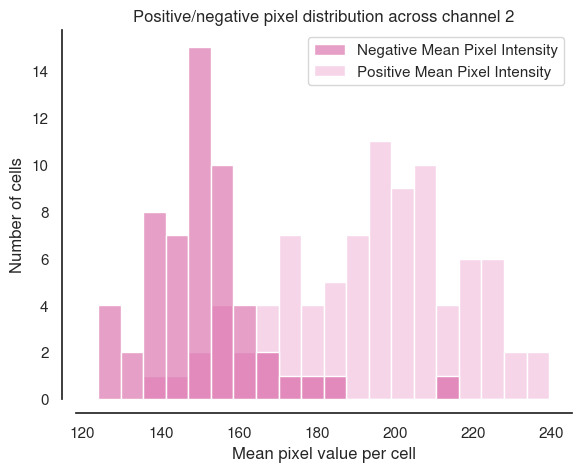

In [166]:
sns.histplot(data = df[channel], bins = 20)
sns.despine(offset = 10)
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}')

## Decide threshold label and replot

In [195]:
threshold = 175


/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

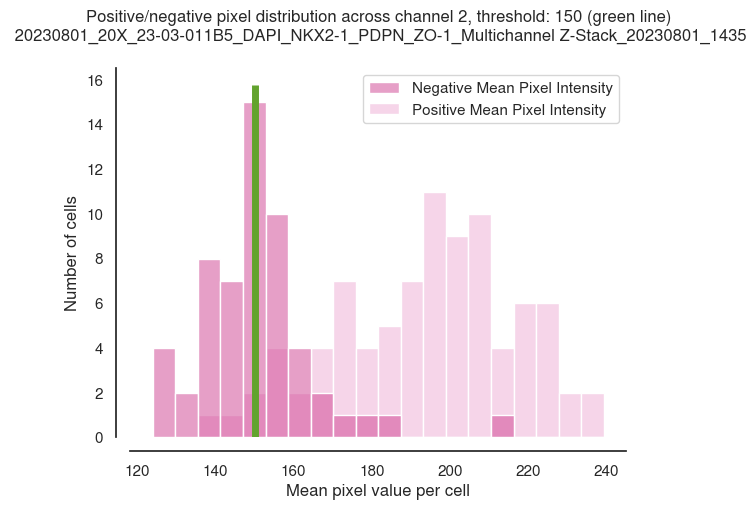

In [168]:
# channel = 1
ax = sns.histplot(data=df[channel], bins=20)
sns.despine(offset=10)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=5)
# plt.text(x=threshold, y=ax.get_ylim()[-1], s='Threshold')
plt.xlabel('Mean pixel value per cell')
plt.ylabel('Number of cells')
plt.title(f'Positive/negative pixel distribution across channel {channel}, threshold: {threshold} (green line)\n {image_name}', pad =20)
# plt.legend([f'Threshold ({threshold})'], loc='lower right')
# ax.text(0.7, 0.8, 
#         f'Threshold ({threshold})',
#         transform=ax.transAxes, fontsize=12,
#         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))
output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold.png')
plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

## Quantify

Quantification of number of different cell types according to manually set thresholds

#### Print number of positive and negative cells

In [196]:
# channel = 1
n_positive = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) >= threshold])
n_negative = len([t for t in tracks if np.max(t.properties['mean_intensity'][:,channel]) < threshold])
print(f'Number of channel {channel} positive cells: {n_positive}')
print(f'Number of channel {channel} negative cells: {n_negative}')
percentage = n_positive / (n_positive+n_negative) *100
print(f'Percentage of positive cells: {percentage:.2f}%')

Number of channel 1 positive cells: 3929
Number of channel 1 negative cells: 2186
Percentage of positive cells: 64.25%


#### Plot the number of cells either side of the threshold

/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dayn/miniconda3/envs/cellpose/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


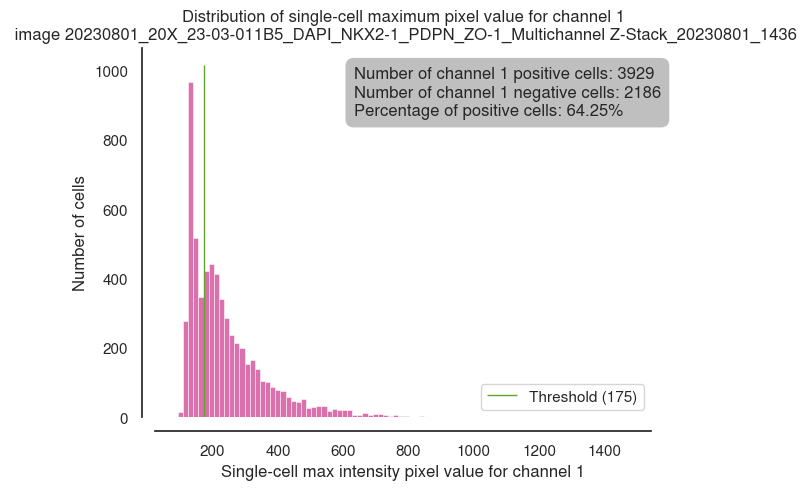

In [197]:
sc_intensities = [np.max(t.properties['mean_intensity'][:,channel]) for t in tracks]
ax = sns.histplot(sc_intensities)
plt.vlines(x=threshold,
           ymax=ax.get_ylim()[-1],
           ymin=ax.get_ylim()[0],
           color=sns.color_palette('PiYG')[-1],  # my favorite colors :D
           linewidth=1)
sns.despine(offset = 10)
plt.xlabel(f'Single-cell max intensity pixel value for channel {channel}')
plt.ylabel('Number of cells')
plt.legend([f'Threshold ({threshold})'], loc='lower right')
ax.text(0.4, 0.95, 
        f'Number of channel {channel} positive cells: {n_positive}\nNumber of channel {channel} negative cells: {n_negative}\nPercentage of positive cells: {percentage:.2f}%',
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='grey', edgecolor='none', alpha=0.5))

image_name = os.path.basename(image_fn).replace('.tif','')
plt.title(f'Distribution of single-cell maximum pixel value for channel {channel}\n image {image_name}')
output_fn = os.path.join(sc_base_dir, f'{image_name}_ch{channel}_threshold_quantification.png')
plt.savefig(output_fn, bbox_inches = 'tight', dpi = 314)

# Save out as df/excel

In [ ]:
### define parameters to plot in table
cols = ['Cell ID', f'Max. int. {channels(0).name}', f'Max. int. {channels(1).name}', f'Max. int. {channels(2).name}', f'Max. int. {channels(3).name}', 'Average X', 'Average Y']
### extract some intial measurements
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)